# Requirements

In [ ]:
# packages required
!pip install pandas numpy matplotlib seaborn scikit-learn mofapy2 mofax imbalanced-learn python-louvain networkx scipy scikit-posthocs

In [78]:
# import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mofax
import networkx as nx
import community as community_louvain
import scipy.stats as stats
import scikit_posthocs as sp
import re
import warnings
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, classification_report, accuracy_score, pairwise_distances
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from mofapy2.run.entry_point import entry_point
from numpy.random import default_rng
from functools import reduce

# Data preparation

In [48]:
# import of clinical data
clinical_data = pd.read_csv('PDAC_data/clinical_data.csv', index_col=0)

# import of multi-omics data
view_circRNA = pd.read_csv('PDAC_data/circRNA.csv', index_col=0)
view_miRNA = pd.read_csv('PDAC_data/miRNA.csv', index_col=0)
view_mRNA = pd.read_csv('PDAC_data/mRNA.csv', index_col=0)
view_phoshoproteome = pd.read_csv('PDAC_data/phosphoproteome_gene.csv', index_col=0)
view_proteome = pd.read_csv('PDAC_data/proteome_gene.csv', index_col=0)
view_SCNA = pd.read_csv('PDAC_data/SCNA_gene.csv', index_col=0)
data = [view_circRNA, view_miRNA, view_mRNA, view_phoshoproteome, view_proteome, view_SCNA] 
labels = ['circRNA', 'miRNA', 'mRNA', 'phoshoproteome', 'proteome', 'SCNA']

In [49]:
# trasposition of data to have samples as rows and features as columns
data = [df.T for df in data]
print("Check for new dimensions (samples, features) after trasposition:")
for label, df in zip(labels, data):
    print(f"{label}: {df.shape}")

Check for new dimensions (samples, features) after trasposition:
circRNA: (137, 3979)
miRNA: (137, 2416)
mRNA: (137, 28057)
phoshoproteome: (137, 8004)
proteome: (137, 11662)
SCNA: (137, 19906)


# Data pre-processing

In [50]:
# data summary

master_patients = set(clinical_data.index)
print(f"Found {len(master_patients)} unique patients in clinical_data.")
summary_stats = []

# iterate over each view to calculate statistics
for view_df, view_name in zip(data, labels):
    
    n_samples, n_features = view_df.shape  
    view_patients = set(view_df.index)  
    overlapping_patients = len(master_patients.intersection(view_patients))
    
    # compute statistics
    total_cells = n_features * n_samples
    na_count = view_df.isna().sum().sum()
    
    if total_cells > 0:
        na_percentage = (na_count / total_cells) * 100
    else:
        na_percentage = 0.0
    
    all_values = view_df.values.flatten()
    all_values_no_na = all_values[~np.isnan(all_values)]
    
    if len(all_values_no_na) > 0:
        global_min = all_values_no_na.min()
        global_max = all_values_no_na.max()
        global_mean = all_values_no_na.mean()
    else:
        # case where all values are NA
        global_min, global_max, global_mean = np.nan, np.nan, np.nan

    stats = {
        "View": view_name,
        "Features": n_features,
        "Samples (Patients)": n_samples,
        "Overlapping_Patients": overlapping_patients, # patients in this view also in clinical data
        "NA_Count": na_count,
        "NA_Percentage": na_percentage,
        "Global_Min": global_min,
        "Global_Mean": global_mean,
        "Global_Max": global_max
    }
    summary_stats.append(stats)

# print summary table
summary_df = pd.DataFrame(summary_stats)
print("\n--- Data Summary Table ---")
print(summary_df.to_markdown(index=False, floatfmt=".2f"))

Found 140 unique patients in clinical_data.

--- Data Summary Table ---
| View           |   Features |   Samples (Patients) |   Overlapping_Patients |   NA_Count |   NA_Percentage |   Global_Min |   Global_Mean |   Global_Max |
|:---------------|-----------:|---------------------:|-----------------------:|-----------:|----------------:|-------------:|--------------:|-------------:|
| circRNA        |       3979 |                  137 |                    137 |          0 |            0.00 |         0.00 |          0.83 |        15.84 |
| miRNA          |       2416 |                  137 |                    137 |     214634 |           64.85 |        -4.35 |          2.49 |        18.68 |
| mRNA           |      28057 |                  137 |                    137 |          0 |            0.00 |         0.00 |          6.25 |        24.77 |
| phoshoproteome |       8004 |                  137 |                    137 |     351329 |           32.04 |        10.94 |         21.81 |  

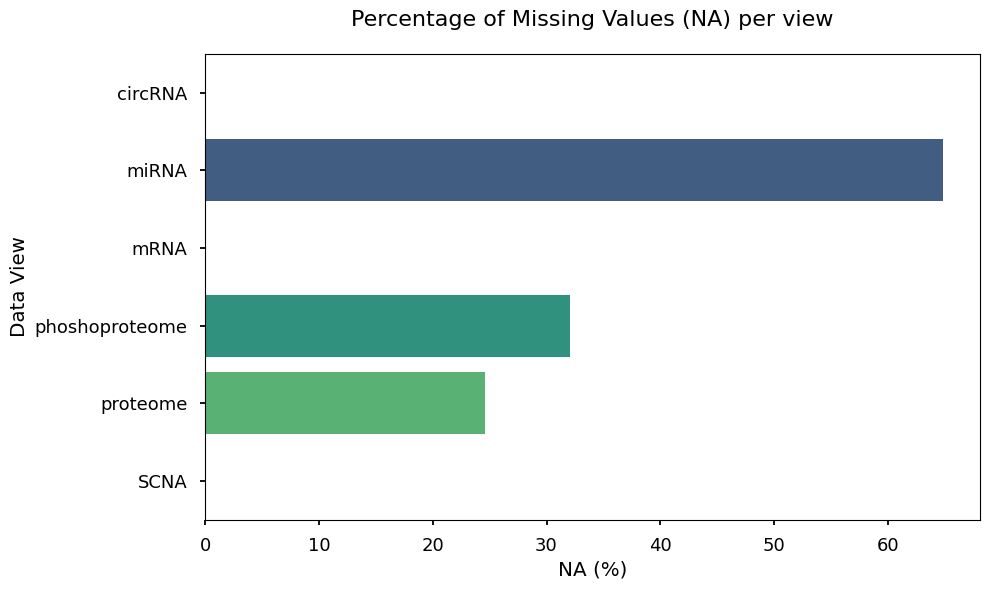

In [51]:
# visualization of NA percentage per view

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(10, 6))
sns.barplot(data=summary_df, x="NA_Percentage", y="View", palette="viridis") 
plt.title("Percentage of Missing Values (NA) per view", fontsize=16, pad=20)
plt.xlabel("NA (%)") 
plt.ylabel("Data View")
plt.tight_layout()

Due to the high number of NA values, we are considering data imputation or removal

Total patients: 137
NA threshold (25%): 34.25 of missing values per feature

--- Summary of features with NA > 25% ---
| View           |   Total_Features |   Features_Over_25pct_NA |   Percentage_Features_Over_25pct_NA |
|:---------------|-----------------:|-------------------------:|------------------------------------:|
| circRNA        |             3979 |                        0 |                                0.00 |
| miRNA          |             2416 |                     2049 |                               84.81 |
| mRNA           |            28057 |                        0 |                                0.00 |
| phoshoproteome |             8004 |                     3422 |                               42.75 |
| proteome       |            11662 |                     3893 |                               33.38 |
| SCNA           |            19906 |                       15 |                                0.08 |


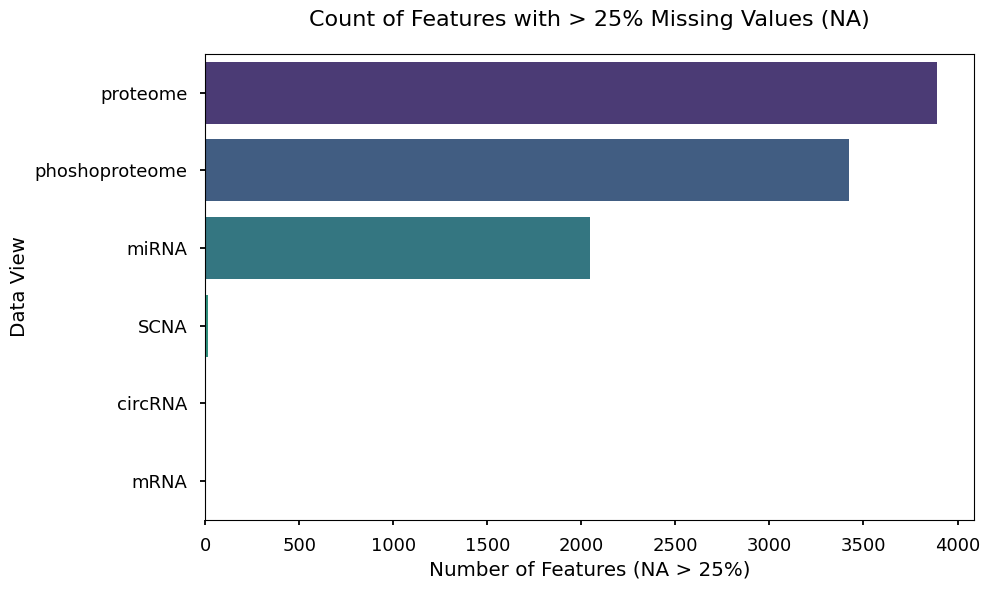

In [52]:
# removal of features with more than 25% NA

total_patients = 137
na_threshold_percentage = 0.25
na_threshold_count = na_threshold_percentage * total_patients

print(f"Total patients: {total_patients}")
print(f"NA threshold (25%): {na_threshold_count:.2f} of missing values per feature")

high_na_stats = []

# iterate over each view to calculate high NA feature statistics
for view_df, view_name in zip(data, labels):
    
    n_samples, n_features = view_df.shape
    na_counts_per_feature = view_df.isna().sum(axis=0)
    
    features_over_threshold_bool = (na_counts_per_feature > na_threshold_count)
    features_exceeding_threshold = features_over_threshold_bool.sum()
    
    # percentage of features exceeding threshold
    if n_features > 0:
        percentage_of_features = (features_exceeding_threshold / n_features) * 100
    else:
        percentage_of_features = 0.0

    stats = {
        "View": view_name,
        "Total_Features": n_features,
        "Features_Over_25pct_NA": features_exceeding_threshold,
        "Percentage_Features_Over_25pct_NA": percentage_of_features
    }
    high_na_stats.append(stats)

high_na_df = pd.DataFrame(high_na_stats)

print("\n--- Summary of features with NA > 25% ---")
print(high_na_df.to_markdown(index=False, floatfmt=".2f"))

# data visualization
plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(10, 6))
sns.barplot(
    data=high_na_df.sort_values("Features_Over_25pct_NA", ascending=False), 
    x="Features_Over_25pct_NA",
    y="View",
    palette="viridis"
)
plt.title("Count of Features with > 25% Missing Values (NA)", fontsize=16, pad=20)
plt.xlabel("Number of Features (NA > 25%)")
plt.ylabel("Data View")
plt.tight_layout()


In [53]:
# removal of features with more than 25% NA

print(f"NA threshold (25%): {na_threshold_count:.2f} of missing values per feature")
print(f"Features with an NA count <= {na_threshold_count:.2f} will be retained.")
print("-" * 60)

filter_summary_stats = []
filtered_data_list = []

# iteration, filtering, and NA counting
for view_df, view_name in zip(data, labels):
    
    n_samples_orig, n_features_orig = view_df.shape
    na_count_original = view_df.isna().sum().sum()
    
    na_counts_per_feature = view_df.isna().sum(axis=0)
    features_to_keep_bool = (na_counts_per_feature <= na_threshold_count)
    features_to_keep_names = view_df.columns[features_to_keep_bool]
    
    filtered_view_df = view_df[features_to_keep_names]
    filtered_data_list.append(filtered_view_df)
    
    n_features_remaining = filtered_view_df.shape[1]
    n_features_removed = n_features_orig - n_features_remaining
    na_count_remaining = filtered_view_df.isna().sum().sum()
    na_count_removed = na_count_original - na_count_remaining
    
    stats = {
        "View": view_name,
        "Original_features": n_features_orig,
        "Removed_Features": n_features_removed,
        "Remaining_Features": n_features_remaining,
        "Original_NAs": na_count_original,
        "Removed_NAs": na_count_removed,
        "Remaining_NAs": na_count_remaining
    }
    filter_summary_stats.append(stats)

data = filtered_data_list

print("\n--- Feature filtering and NA removal summary ---")
summary_df = pd.DataFrame(filter_summary_stats)
print(summary_df.to_markdown(index=False, floatfmt=".0f"))

NA threshold (25%): 34.25 of missing values per feature
Features with an NA count <= 34.25 will be retained.
------------------------------------------------------------

--- Feature filtering and NA removal summary ---
| View           |   Original_features |   Removed_Features |   Remaining_Features |   Original_NAs |   Removed_NAs |   Remaining_NAs |
|:---------------|--------------------:|-------------------:|---------------------:|---------------:|--------------:|----------------:|
| circRNA        |                3979 |                  0 |                 3979 |              0 |             0 |               0 |
| miRNA          |                2416 |               2049 |                  367 |         214634 |        212258 |            2376 |
| mRNA           |               28057 |                  0 |                28057 |              0 |             0 |               0 |
| phoshoproteome |                8004 |               3422 |                 4582 |         351329 


--- Data Summary Table (Post-Filtering) ---
| View           |   Features |   Samples (Patients) |   Overlapping_Patients |   NA_Count |   NA_Percentage |
|:---------------|-----------:|---------------------:|-----------------------:|-----------:|----------------:|
| circRNA        |       3979 |                  137 |                    137 |          0 |            0.00 |
| miRNA          |        367 |                  137 |                    137 |       2376 |            4.73 |
| mRNA           |      28057 |                  137 |                    137 |          0 |            0.00 |
| phoshoproteome |       4582 |                  137 |                    137 |      24237 |            3.86 |
| proteome       |       7769 |                  137 |                    137 |      29508 |            2.77 |
| SCNA           |      19891 |                  137 |                    137 |        137 |            0.01 |


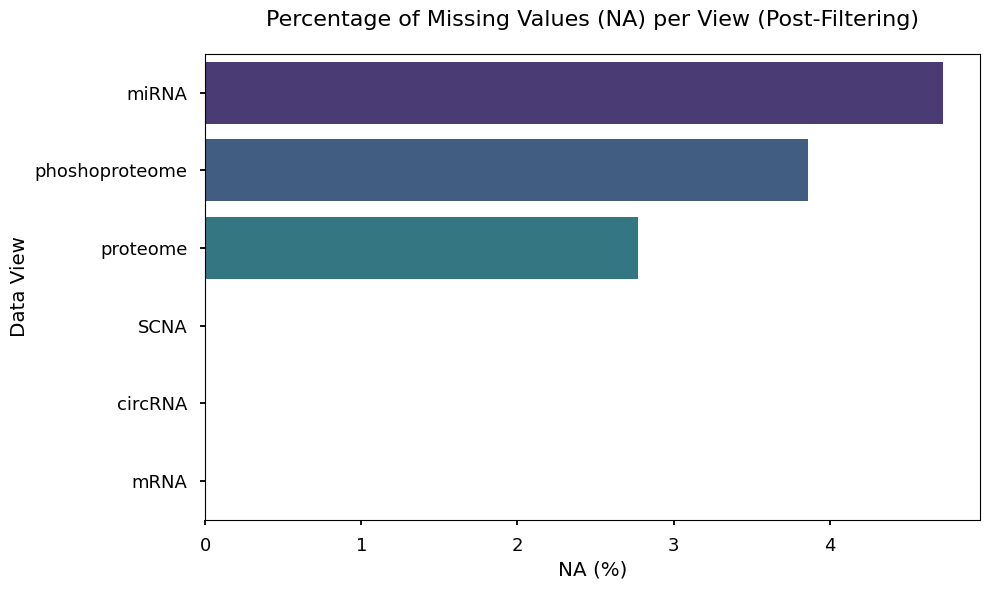

In [54]:
# recalculate NA statistics after filtering

try:
    master_patients = set(clinical_data.index)
except NameError:
    print("Warning: 'clinical_data' not found. The 'Overlapping_Patients' count might be incorrect.")
    master_patients = set()

summary_stats_post_filter = []

for view_df, view_name in zip(data, labels):
    
    n_samples, n_features = view_df.shape
    view_patients = set(view_df.index)
    overlapping_patients = len(master_patients.intersection(view_patients))
    
    total_cells = n_features * n_samples
    na_count = view_df.isna().sum().sum()
    
    if total_cells > 0:
        na_percentage = (na_count / total_cells) * 100
    else:
        na_percentage = 0.0
    
    stats = {
        "View": view_name,
        "Features": n_features,
        "Samples (Patients)": n_samples,
        "Overlapping_Patients": overlapping_patients,
        "NA_Count": na_count,
        "NA_Percentage": na_percentage
    }
    summary_stats_post_filter.append(stats)

summary_df_post_filter = pd.DataFrame(summary_stats_post_filter)
print("\n--- Data Summary Table (Post-Filtering) ---")
print(summary_df_post_filter.to_markdown(index=False, floatfmt=".2f"))

plt.style.use('seaborn-v0_8-talk') 
plt.figure(figsize=(10, 6))
sns.barplot(
    data=summary_df_post_filter.sort_values("NA_Percentage", ascending=False), 
    x="NA_Percentage", 
    y="View", 
    palette="viridis"
) 

plt.title("Percentage of Missing Values (NA) per View (Post-Filtering)", fontsize=16, pad=20)
plt.xlabel("NA (%)") 
plt.ylabel("Data View")
plt.tight_layout()

# Data imputation

We tried using **MissForest**, but due to the high number of features, the execution time is too long and it require high computational resources

In [55]:
# Data imputation with KNNImputer and k optimization

# parameters
K_VALUES_TO_TEST = [3, 5, 7, 9, 11, 13, 15, 17]
RANDOM_STATE = 42
rng = default_rng(RANDOM_STATE)
TEST_HOLE_FRACTION = 0.05  # percentage of known values to use as test holes
MIN_TEST_HOLES = 10000     # ensure at least 10,000 test holes if possible

# common samples
common_samples = reduce(np.intersect1d, [df.index for df in data])
common_samples = sorted(list(common_samples))
print(f"Found {len(common_samples)} common samples.")

# alignment and imputation
data_aligned_imputed = []
imputation_summary_list = []

print("\n--- Starting KNN Imputation and Alignment (with k Optimization) ---")

for view_name, df in zip(labels, data):
    
    df_aligned = df.loc[common_samples]
    original_index = df_aligned.index
    original_columns = df_aligned.columns
    
    if df_aligned.isnull().values.any():
        print(f"\n--- View: {view_name} ---")
        
        # compute global SD as benchmark
        global_sd = np.nanstd(df_aligned.values)
        print(f"Global View Standard Deviation (SD): {global_sd:.4f}")
        
        print("Running Cross-Validation to find optimal k...")
        
        df_train_cv = df_aligned.copy()
        non_na_rows, non_na_cols = np.where(df_train_cv.notna())
        n_total_known = len(non_na_rows)
        
        # select number of test holes
        n_holes_from_fraction = int(n_total_known * TEST_HOLE_FRACTION)
        n_test_holes_target = max(MIN_TEST_HOLES, n_holes_from_fraction)
        max_possible_holes = int(n_total_known * 0.95)
        n_test_holes = min(n_test_holes_target, max_possible_holes)

        if n_test_holes == 0:
            print("WARNING: Cannot create 'test holes' (data too small or sparse).")
            print("Default k=11 will be used for this view.")
            best_k = 11
            best_rmse = np.nan
        else:
            # create test holes
            test_indices_flat = rng.choice(n_total_known, n_test_holes, replace=False)
            test_rows = non_na_rows[test_indices_flat]
            test_cols = non_na_cols[test_indices_flat]
            true_values = []
            for r, c in zip(test_rows, test_cols):
                true_values.append(df_train_cv.iloc[r, c])
                df_train_cv.iloc[r, c] = np.nan
            
            errors = {}
            print(f"Test on {n_test_holes} 'test holes'...")
            # test different k values
            for k in K_VALUES_TO_TEST:
                imputer_cv = KNNImputer(n_neighbors=k, weights='distance')
                imputed_array_cv = imputer_cv.fit_transform(df_train_cv)
                
                imputed_values = []
                for r, c in zip(test_rows, test_cols):
                    imputed_values.append(imputed_array_cv[r, c])
                # compute RMSE, root mean squared error
                rmse = np.sqrt(mean_squared_error(true_values, imputed_values))
                errors[k] = rmse
            
            best_k = min(errors, key=errors.get)
            best_rmse = errors[best_k]
            
            print(f" -> Optimal K found: {best_k} (RMSE: {best_rmse:.4f})")
            print(f" -> Comparison: RMSE ({best_rmse:.4f}) vs. SD ({global_sd:.4f})")
            
        stats_to_save = {
            "View": view_name,
            "SD": global_sd,
            "RMSE": best_rmse,
            "Optimal_K": best_k
        }
        imputation_summary_list.append(stats_to_save)

        # final imputation with best k
        print(f"Performing final imputation on '{view_name}' with k={best_k}...")
        final_imputer = KNNImputer(n_neighbors=best_k, weights="distance")
        
        df_imputed_array = final_imputer.fit_transform(df_aligned)
        df_final = pd.DataFrame(df_imputed_array, 
                                index=original_index, 
                                columns=original_columns)
    
    else:
        print(f"\nView '{view_name}' has no NaNs. Ready.")
        df_final = df_aligned
        
    data_aligned_imputed.append(df_final)
    print(f"View '{view_name}' ready. Final dimensions: {df_final.shape}")

print("\n--- Data Ready for MOFA ---")
print("Final NaN check (should be 0 for all):")
for label, df in zip(labels, data_aligned_imputed):
    print(f"{label}: {df.shape}, Total NaN values: {df.isnull().sum().sum()}")

print("\n--- Imputation summary ---")
imputation_summary_df = pd.DataFrame(imputation_summary_list)
print(imputation_summary_df.to_markdown(index=False, floatfmt=".4f"))

Found 137 common samples.

--- Starting KNN Imputation and Alignment (with k Optimization) ---

View 'circRNA' has no NaNs. Ready.
View 'circRNA' ready. Final dimensions: (137, 3979)

--- View: miRNA ---
Global View Standard Deviation (SD): 3.5659
Running Cross-Validation to find optimal k...
Test on 10000 'test holes'...
 -> Optimal K found: 15 (RMSE: 0.7715)
 -> Comparison: RMSE (0.7715) vs. SD (3.5659)
Performing final imputation on 'miRNA' with k=15...
View 'miRNA' ready. Final dimensions: (137, 367)

View 'mRNA' has no NaNs. Ready.
View 'mRNA' ready. Final dimensions: (137, 28057)

--- View: phoshoproteome ---
Global View Standard Deviation (SD): 2.1639
Running Cross-Validation to find optimal k...
Test on 30174 'test holes'...
 -> Optimal K found: 11 (RMSE: 0.4259)
 -> Comparison: RMSE (0.4259) vs. SD (2.1639)
Performing final imputation on 'phoshoproteome' with k=11...
View 'phoshoproteome' ready. Final dimensions: (137, 4582)

--- View: proteome ---
Global View Standard Deviati

We tried applying **KNN**, attempting to find tailored k values for each view by choosing the one that minimizes the RMSE and comparing it with the standard deviation. Using the KNN imputer, we removed the few' remaining NA values

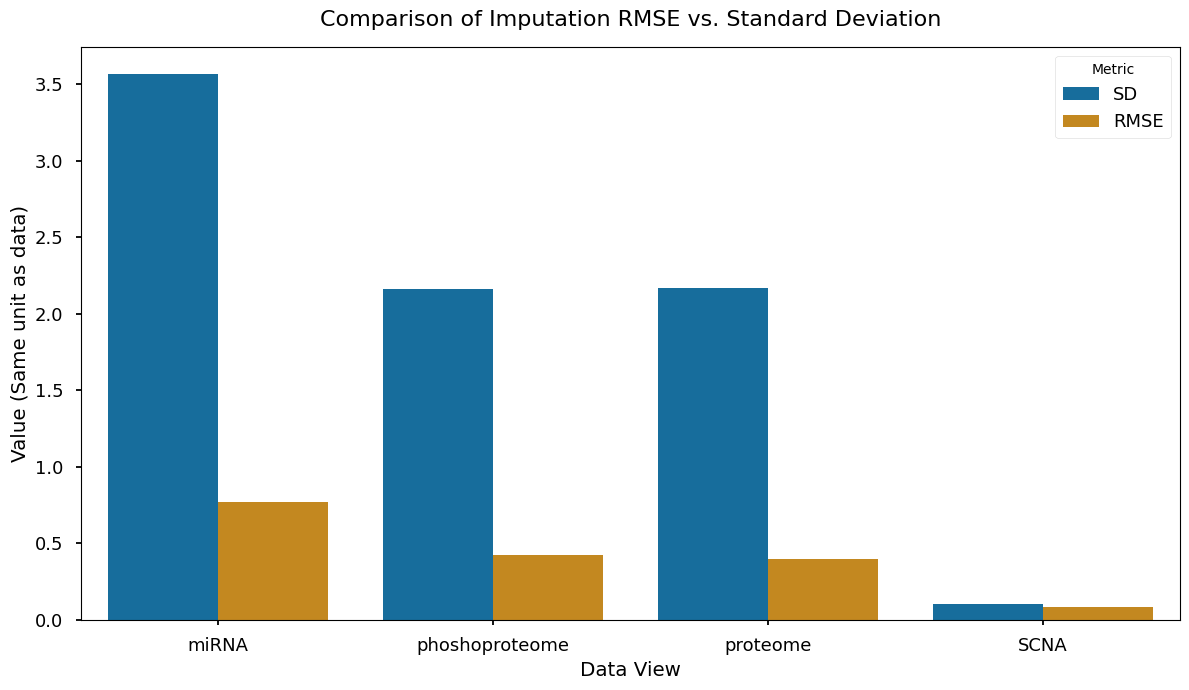

In [56]:
# RMSE vs SD plot

results_df = imputation_summary_df
df_melted = results_df.melt(
    id_vars=["View"], 
    value_vars=["SD", "RMSE"], 
    var_name="Metric", 
    value_name="Value"
)

plt.style.use('seaborn-v0_8-talk')
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(
    data=df_melted, 
    x="View", 
    y="Value", 
    hue="Metric",
    palette="colorblind",
    ax=ax
)

ax.set_title("Comparison of Imputation RMSE vs. Standard Deviation", fontsize=16, pad=15)
ax.set_ylabel("Value (Same unit as data)")
ax.set_xlabel("Data View")
ax.legend(title="Metric")

plt.tight_layout()
plt.show()


RMSE is always lower then SD -> good results


--- View 'miRNA' ---
Sample distribution:
Contained Imputed      110
Originally Complete     27
Name: count, dtype: int64

--- View 'phoshoproteome' ---
Sample distribution:
Contained Imputed    137
Name: count, dtype: int64

--- View 'proteome' ---
Sample distribution:
Contained Imputed    137
Name: count, dtype: int64

--- View 'SCNA' ---
Sample distribution:
Originally Complete    92
Contained Imputed      45
Name: count, dtype: int64


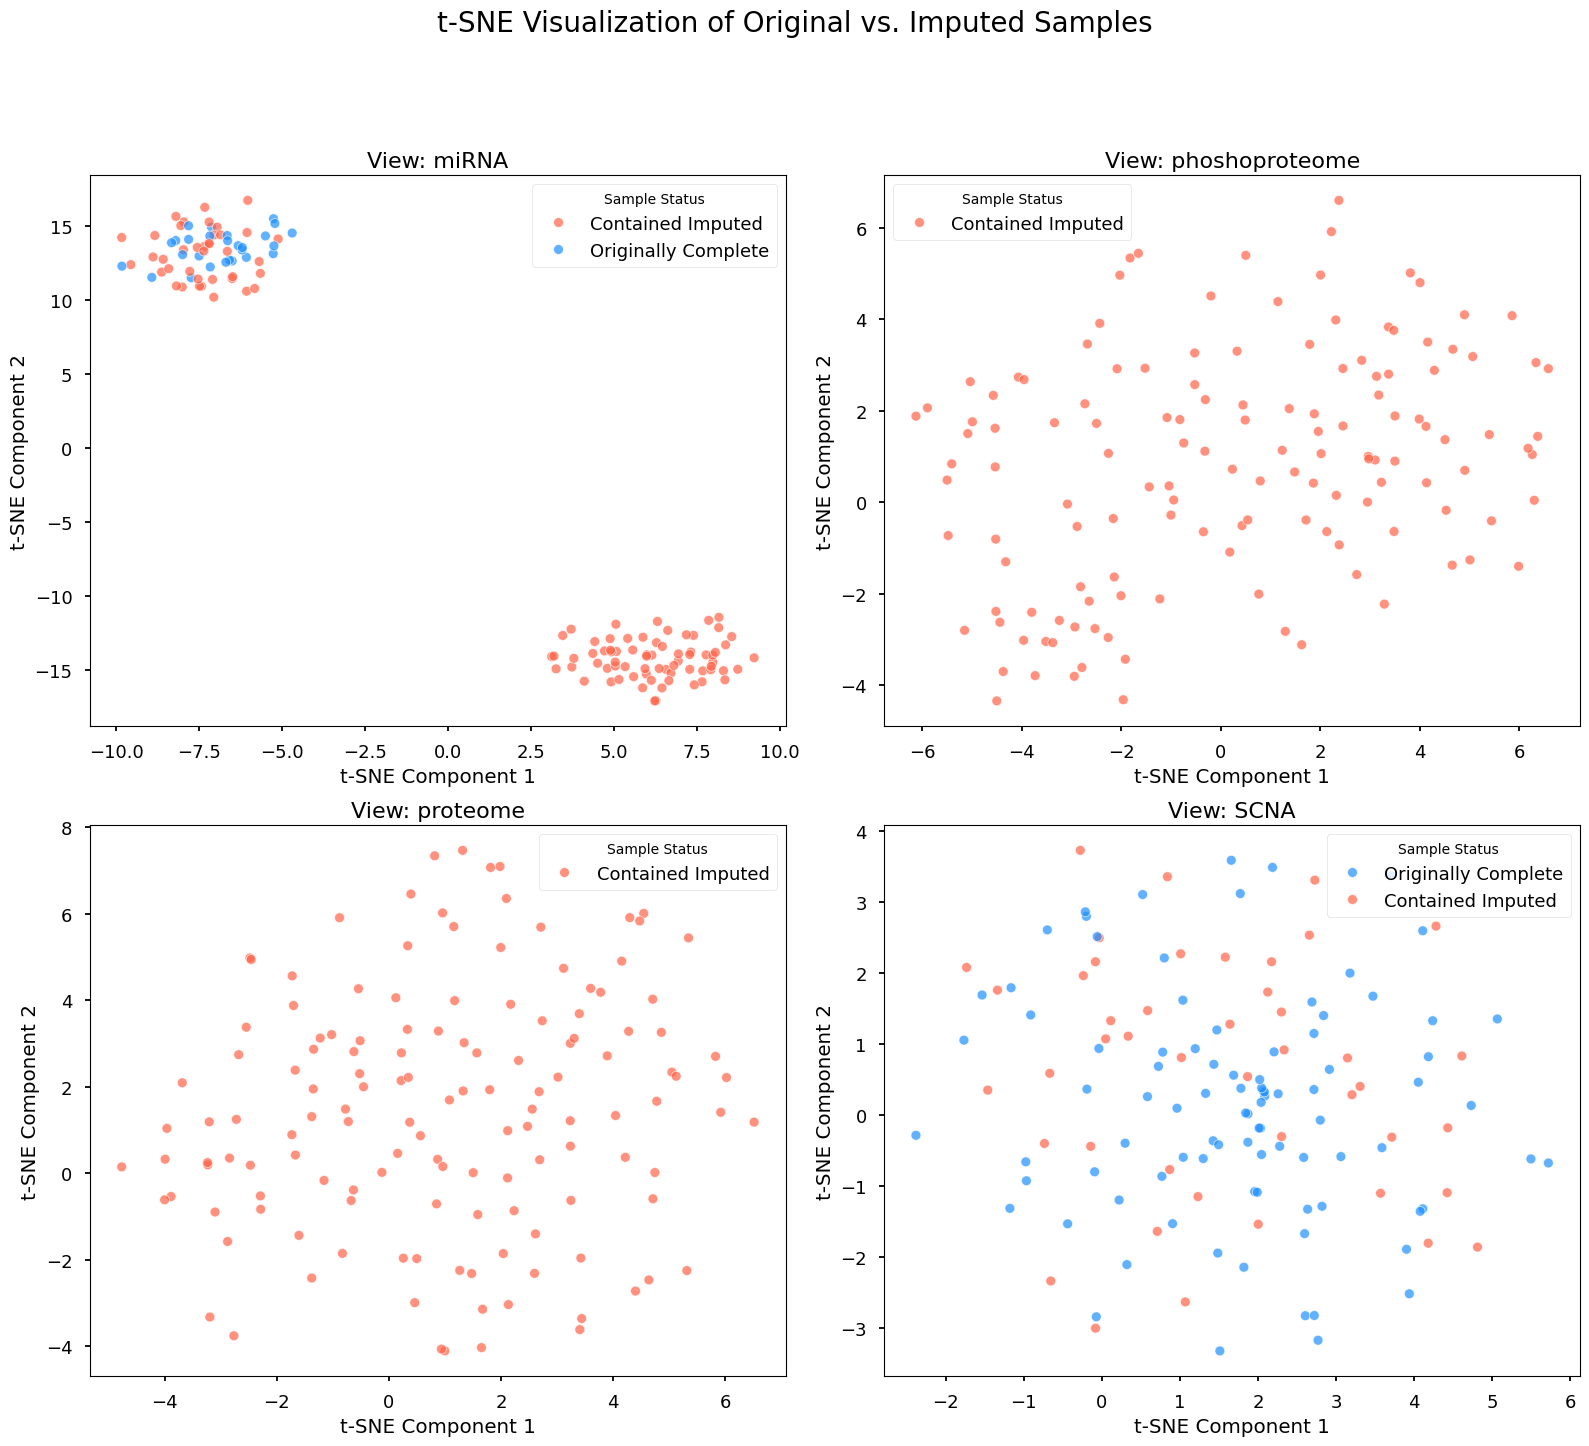


--- View 'circRNA' ---
SKIP: No imputation performed for this view

--- View 'mRNA' ---
SKIP: No imputation performed for this view


In [57]:
# t-SNE visualization of imputed vs original samples

RANDOM_STATE_TSNE = 42
views_to_plot = imputation_summary_df["View"]

plottable_views = [
    (idx, name) for idx, name in enumerate(labels) 
    if name in views_to_plot.values
]

num_plots = len(plottable_views)
rows = 2
cols = 2

if num_plots == 0:
    print("No imputed views to display.")
elif num_plots > (rows * cols):
    print(f"Warning: Found {num_plots} views to plot, but only {rows*cols} slots available. Plotting first {rows*cols}.")
    plottable_views = plottable_views[:rows*cols]
    
if num_plots > 0:
    
    plt.style.use('seaborn-v0_8-talk')
    fig, axes = plt.subplots(rows, cols, figsize=(16, 14))
    flat_axes = axes.flatten()
    plot_index = 0
    
    palette = {
        "Originally Complete": "dodgerblue",
        "Contained Imputed": "tomato" 
    }

    # iterate over each view that needs plotting
    for view_index, view_name in plottable_views:
        
        ax = flat_axes[plot_index]
            
        print(f"\n--- View '{view_name}' ---")

        df_imputed = data_aligned_imputed[view_index]
        df_original_aligned = data[view_index].loc[common_samples]

        rows_with_na = df_original_aligned.isnull().any(axis=1)
        status_labels = rows_with_na.map({
            True: 'Contained Imputed', 
            False: 'Originally Complete'
        })
        
        print("Sample distribution:")
        print(status_labels.value_counts())

        # t-SNE execution
        tsne = TSNE(
            n_components=2, 
            perplexity=30, 
            random_state=RANDOM_STATE_TSNE,
            max_iter=1000,
            
        )
        tsne_results = tsne.fit_transform(df_imputed)

        plot_df = pd.DataFrame(
            data=tsne_results, 
            columns=['t-SNE 1', 't-SNE 2'],
            index=df_imputed.index 
        )
        plot_df['Status'] = status_labels

        sns.scatterplot(
            data=plot_df,
            x='t-SNE 1',
            y='t-SNE 2',
            hue='Status',
            palette=palette,
            alpha=0.7,
            s=50,
            ax=ax
        )
        
        ax.set_title(f"View: {view_name}", fontsize=16)
        ax.set_xlabel("t-SNE Component 1")
        ax.set_ylabel("t-SNE Component 2")
        ax.legend(title="Sample Status")
        
        plot_index += 1
        
    # hide unused subplots
    for i in range(num_plots, len(flat_axes)):
        flat_axes[i].set_visible(False)
    
    fig.suptitle("t-SNE Visualization of Original vs. Imputed Samples", fontsize=20, y=1.03)
    plt.tight_layout(rect=[0, 0, 1, 0.97])
    plt.show()

# cases where imputation was skipped
for view_index, view_name in enumerate(labels):
    if view_name not in views_to_plot.values:
        print(f"\n--- View '{view_name}' ---")
        print("SKIP: No imputation performed for this view")

When there are only imputed values, it means that all patients contained at least one feature with a missing value

# Data preparation for MOFA

In [58]:
# data standardization computing the z-score

data_scaled = []
scaler = StandardScaler()

print("Performing Standardization (Mean=0, Variance=1):\n")

for view_df, view_name in zip(data_aligned_imputed, labels):

    original_index = view_df.index
    original_columns = view_df.columns
    scaled_array = scaler.fit_transform(view_df)
    scaled_df = pd.DataFrame(
        scaled_array,
        index=original_index,
        columns=original_columns
    )
    
    data_scaled.append(scaled_df)
    print(f"View '{view_name}' scaled. New mean ~ {scaled_df.mean().mean():.2f}, New SD ~ {scaled_df.std().mean():.2f}")

Performing Standardization (Mean=0, Variance=1):

View 'circRNA' scaled. New mean ~ 0.00, New SD ~ 0.80
View 'miRNA' scaled. New mean ~ 0.00, New SD ~ 1.00
View 'mRNA' scaled. New mean ~ -0.00, New SD ~ 0.93
View 'phoshoproteome' scaled. New mean ~ 0.00, New SD ~ 1.00
View 'proteome' scaled. New mean ~ 0.00, New SD ~ 1.00
View 'SCNA' scaled. New mean ~ 0.00, New SD ~ 1.00


In [59]:
# filtering based on variance (top 80% variance, then remove zero variance left)

TOP_VARIANCE_PERCENTAGE = 0.80 
data_final_mofa = []

print(f"Performing filtering: Top {TOP_VARIANCE_PERCENTAGE*100}% then zero variance removal\n")

for view_df, view_name in zip(data_scaled, labels):
    
    total_features_original = view_df.shape[1]

    # fitering based on variance
    n_features_80_percent = int(np.ceil(total_features_original * TOP_VARIANCE_PERCENTAGE))
    feature_variances = view_df.var(axis=0)
    top_80_percent_series = feature_variances.nlargest(n_features_80_percent)
    
    # from the Top 80%, keep only those with variance > 0
    final_features_series = top_80_percent_series[top_80_percent_series > 0]
    
    final_top_features_names = final_features_series.index
    filtered_df = view_df[final_top_features_names]
    
    print(f"View '{view_name}' (Shape: {view_df.shape}) -> Filtered (Shape: {filtered_df.shape}, {len(final_top_features_names)} final features)")
    data_final_mofa.append(filtered_df)

Performing filtering: Top 80.0% then zero variance removal

View 'circRNA' (Shape: (137, 3979)) -> Filtered (Shape: (137, 3167), 3167 final features)
View 'miRNA' (Shape: (137, 367)) -> Filtered (Shape: (137, 294), 294 final features)
View 'mRNA' (Shape: (137, 28057)) -> Filtered (Shape: (137, 22446), 22446 final features)
View 'phoshoproteome' (Shape: (137, 4582)) -> Filtered (Shape: (137, 3666), 3666 final features)
View 'proteome' (Shape: (137, 7769)) -> Filtered (Shape: (137, 6216), 6216 final features)
View 'SCNA' (Shape: (137, 19891)) -> Filtered (Shape: (137, 15913), 15913 final features)


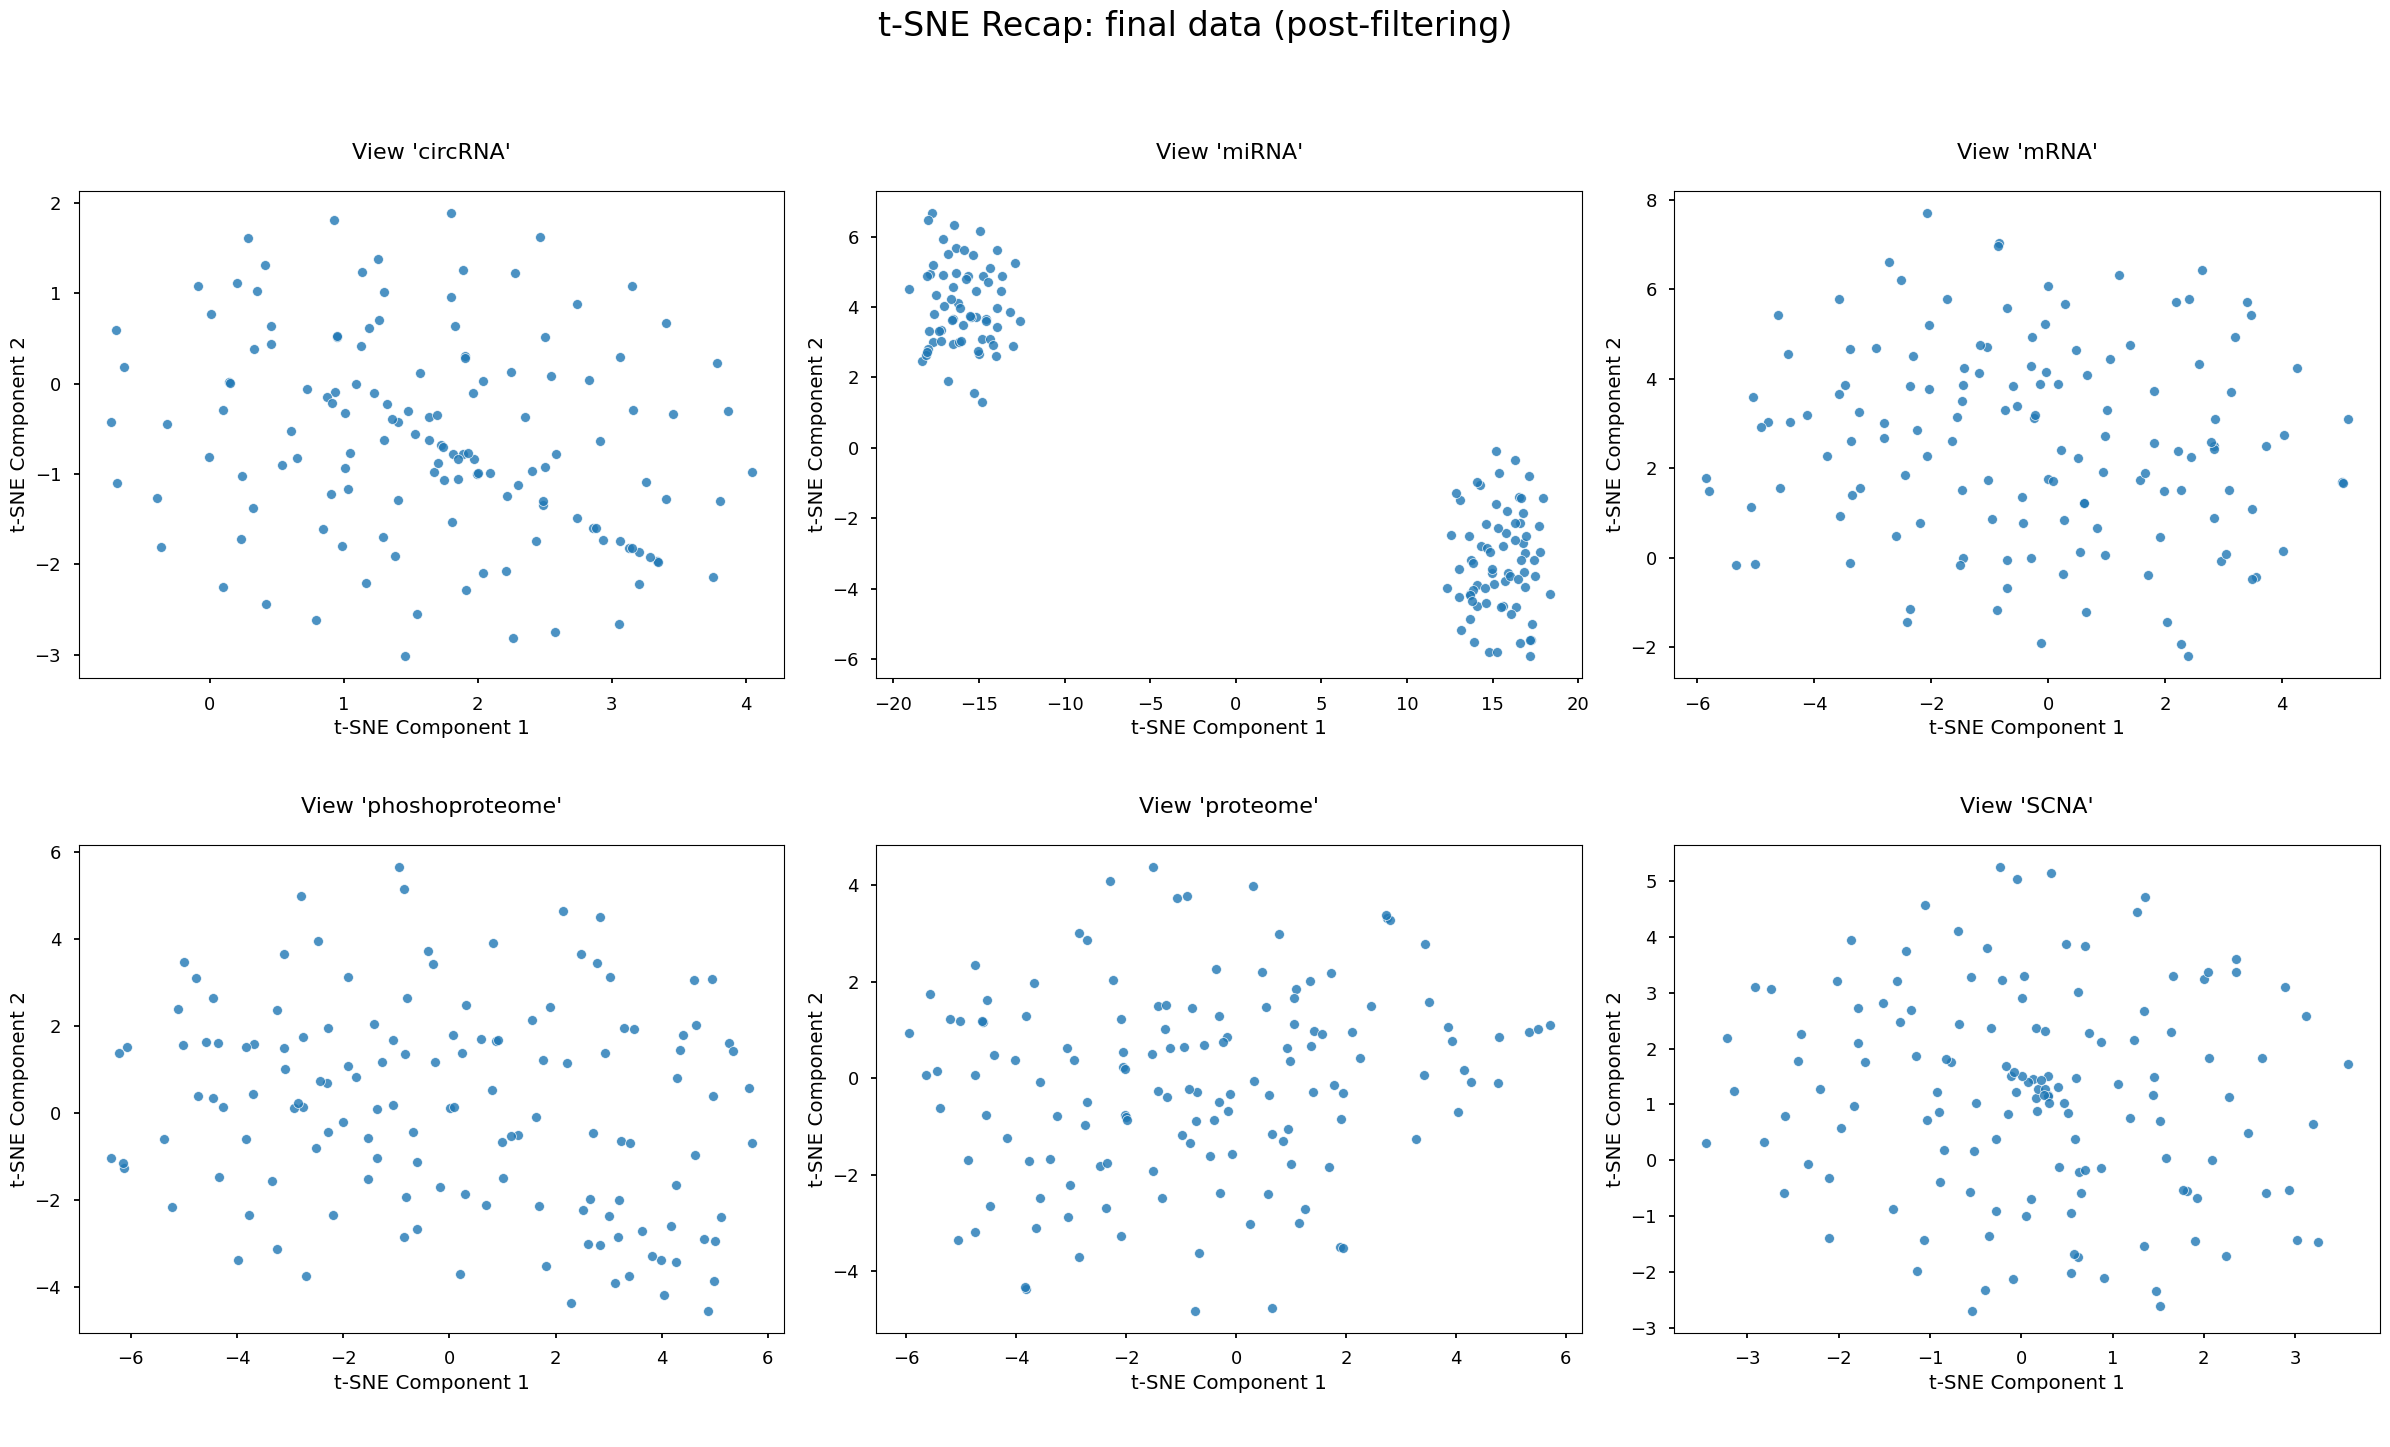

In [60]:
# t-SNE recap of final data (post-filtering)

RANDOM_STATE_TSNE = 42 
rows = 2
cols = 3

plt.style.use('seaborn-v0_8-talk')
fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 7)) 
flat_axes = axes.flatten()
plot_index = 0

# iterate over each final DataFrame
for view_df, view_name in zip(data_final_mofa, labels):
    
    if plot_index >= len(flat_axes):
        print(f"\nWarning: More views than grid slots ({len(flat_axes)}). Skipping view '{view_name}'.")
        break
        
    ax = flat_axes[plot_index]

    tsne = TSNE(
        n_components=2, 
        perplexity=30.0, # safe standard value, must be < number of samples
        random_state=RANDOM_STATE_TSNE,
        max_iter=1000
    )
    
    tsne_results = tsne.fit_transform(view_df)

    plot_df = pd.DataFrame(
        data=tsne_results, 
        columns=['t-SNE 1', 't-SNE 2']
    )

    sns.scatterplot(
        data=plot_df,
        x='t-SNE 1',
        y='t-SNE 2',
        alpha=0.8,
        s=50, # Point size
        ax=ax
    )

    ax.set_title(f"View '{view_name}'\n", fontsize=16)
    ax.set_xlabel("t-SNE Component 1\n\n")
    ax.set_ylabel("t-SNE Component 2")
    
    plot_index += 1

# --- 4. Finalize and Show Grid ---

# Hide any remaining unused axes
for i in range(plot_index, len(flat_axes)):
    flat_axes[i].set_visible(False)

fig.suptitle("t-SNE Recap: final data (post-filtering)", fontsize=24, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98])

plt.show()

# Data integration with MOFA

In [61]:
# MOFA integration

# initialize entry point
print("Inizializzazione MOFA entry_point...")
ent = entry_point()

print("\nApplying unique suffixes to feature names (e.g., GENE1_mRNA)...")
data_views_renamed = []
for df, label in zip(data_final_mofa, labels):
    df_copy = df.copy()
    new_column_names = [f"{col}_{label}" for col in df_copy.columns]
    df_copy.columns = new_column_names
    data_views_renamed.append(df_copy)
print("Feature names made unique.")

# data preparation for the entry_point API
data_mat_for_mofa = [ [df.values] for df in data_views_renamed ]
sample_names = [list(common_samples)] 
feature_names = [ list(df.columns) for df in data_views_renamed ]

# we use 6 Gaussian likelihoods (one per view) because data is continuous (bernoulli is for binary, poisson for counts)
likelihoods = ["gaussian"] * len(labels)

# load data into MOFA model
print("\nLoading data (matrix format) into the model...")
ent.set_data_matrix(
    data_mat_for_mofa, 
    likelihoods = likelihoods,
    views_names = labels,
    features_names = feature_names,
    samples_names = sample_names
)
print("Data loaded successfully.")

# set model options
print("\nSetting up model options...")
ent.set_model_options(
    factors = 15,               # number of latent factors
    spikeslab_weights = True,   # automatic relevance for features weights (0 per irrelevant features)
    ard_weights = True          # automatic relevance determination for weights
)

# set training options
print("\nSetting up training options...")
ent.set_train_options(
    convergence_mode = "fast",  # fast for quicker convergence
    dropR2 = 0.001,             # stop if R2 improvement < 0.1%  
    gpu_mode = False,           # disable GPU (CUDA not available)
    seed = 42                   # for reproducibility
)

# build and train the model
print("\n--- Starting MOFA Training ---")
ent.build()
ent.run()
print("--- Training Completed ---")


# save the weights of model
outfile = "PDAC_mofa_model_ok.hdf5"
ent.save(outfile=outfile)
print(f"\nModel successfully saved to: {outfile}")

Inizializzazione MOFA entry_point...

        #########################################################
        ###           __  __  ____  ______                    ### 
        ###          |  \/  |/ __ \|  ____/\    _             ### 
        ###          | \  / | |  | | |__ /  \ _| |_           ### 
        ###          | |\/| | |  | |  __/ /\ \_   _|          ###
        ###          | |  | | |__| | | / ____ \|_|            ###
        ###          |_|  |_|\____/|_|/_/    \_\              ###
        ###                                                   ### 
        ######################################################### 
       
 
        

Applying unique suffixes to feature names (e.g., GENE1_mRNA)...
Feature names made unique.

Loading data (matrix format) into the model...
Groups names not provided, using default naming convention:
- group1, group2, ..., groupG

Successfully loaded view='circRNA' group='group0' with N=137 samples and D=3167 features...
Successfully loaded v


MOFA Model loaded successfully.
Factor matrix (Z) extracted. Dimensions: (137, 13)

Running t-SNE on all 13 factors...


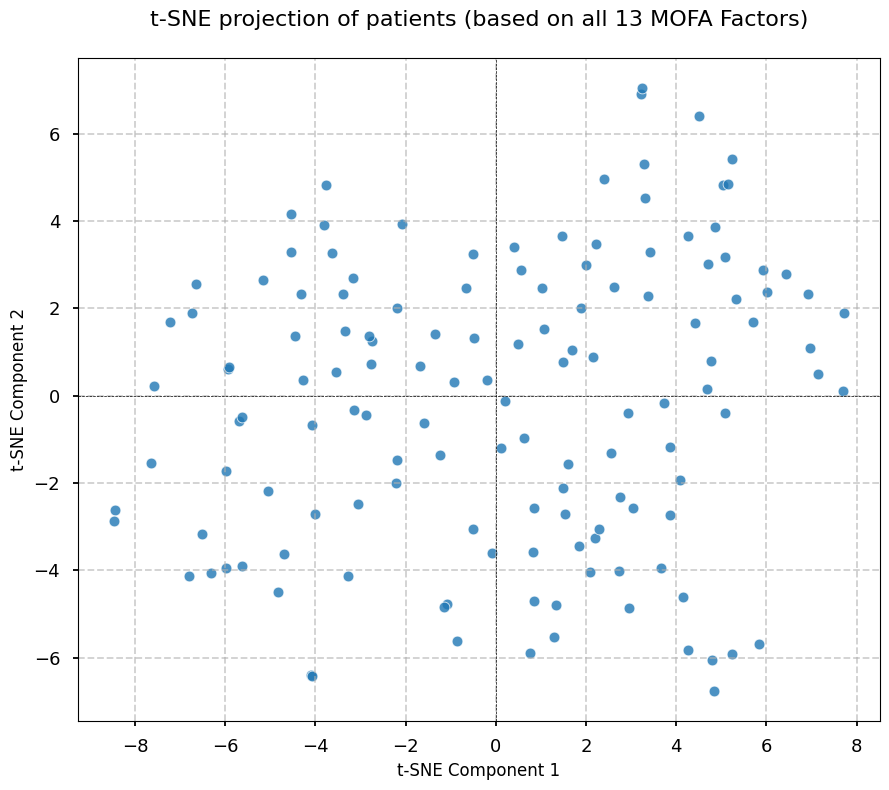

In [62]:
# t-SNE visualization of MOFA factors

# load the model
model_file = "PDAC_mofa_model_ok.hdf5"
model = mofax.mofa_model(model_file)
print("\nMOFA Model loaded successfully.")

# extract factors matrix
factors_df = model.get_factors(df=True)
N_FACTORS = factors_df.shape[1]
print(f"Factor matrix (Z) extracted. Dimensions: {factors_df.shape}")

# t-SNE execution
RANDOM_STATE_TSNE = 42
print(f"\nRunning t-SNE on all {N_FACTORS} factors...")

tsne = TSNE(
    n_components=2, 
    perplexity=30.0, # Standard value
    random_state=RANDOM_STATE_TSNE,
    max_iter=1000
)

# apply t-SNE to the factor matrix
tsne_results = tsne.fit_transform(factors_df)

plot_df = pd.DataFrame(
    data=tsne_results, 
    columns=['t-SNE Component 1', 't-SNE Component 2'],
    index=factors_df.index
)

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(9, 8))
sns.scatterplot(
    data=plot_df,
    x='t-SNE Component 1',
    y='t-SNE Component 2',
    s=60,
    alpha=0.8
)
plt.title(f"t-SNE projection of patients (based on all {N_FACTORS} MOFA Factors)\n", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.grid(linestyle="--", alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=0.5)
plt.axvline(0, color='black', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# close the model
model.close()

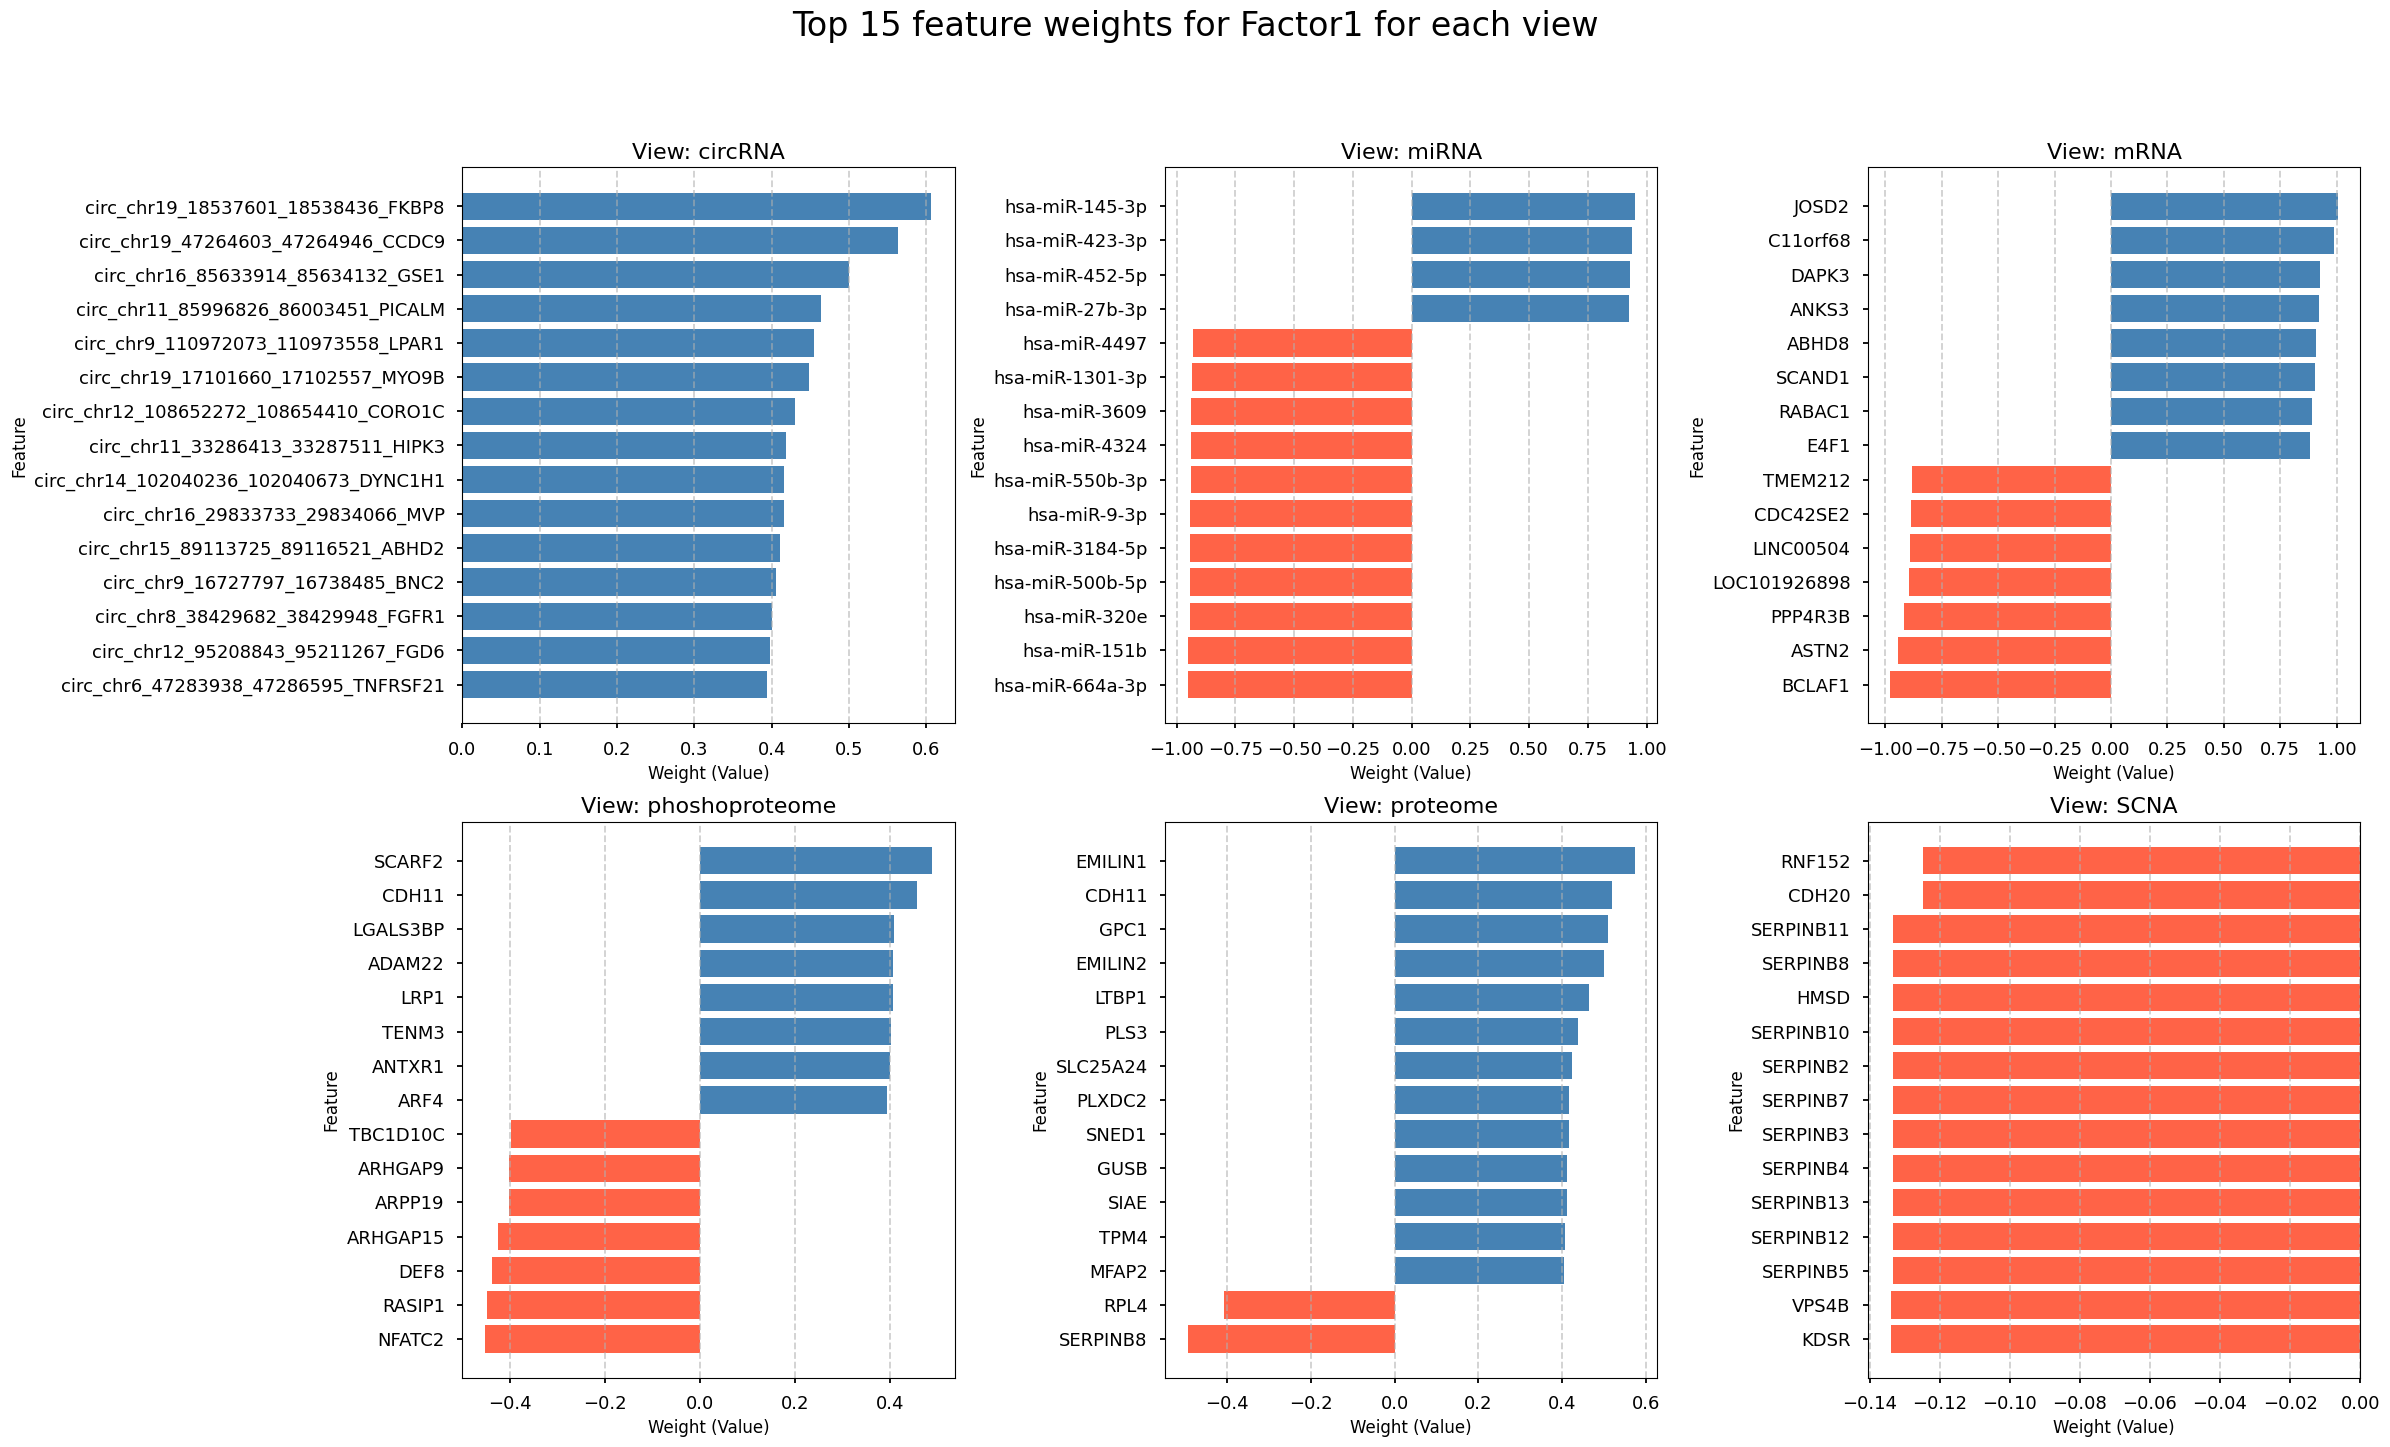

In [63]:
# Weights (W) analysis and plotting top features per factor 1

# load the model
model_file = "PDAC_mofa_model_ok.hdf5"
model = mofax.mofa_model(model_file)

# analyze weights for a specific factor
factor_to_analyze = "Factor1"           # factor name           
N_top_features = 15                     # fetures per view

top_features_df = model.get_top_features(
    factors=factor_to_analyze,
    n_features=N_top_features,
    df=True
)

plt.style.use('seaborn-v0_8-talk')
n_views = len(labels)
rows = 2
cols = 3
total_plots = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(cols * 8, rows * 7)) 
flat_axes = axes.flatten()
plot_index = 0

for view_name in labels:
    
    if plot_index >= total_plots:
        print(f"  Grid full (2x3). Skipping plot for: {view_name}")
        break
        
    ax = flat_axes[plot_index]
    view_features_df = top_features_df[top_features_df["view"] == view_name]
    if view_features_df.empty:
        print(f"  View '{view_name}' has no significant weights for {factor_to_analyze}.")
        ax.set_visible(False)
        plot_index += 1
        continue
        
    view_features_df = view_features_df.sort_values(by="value")
    view_features_df["feature_clean"] = view_features_df["feature"].str.replace(f"_{view_name}$", "", regex=True)
    colors = ['tomato' if w < 0 else 'steelblue' for w in view_features_df["value"]]
    
    ax.barh(
        view_features_df["feature_clean"], 
        view_features_df["value"],
        color=colors
    )
    
    ax.set_title(f"View: {view_name}", fontsize=16)
    ax.set_xlabel("Weight (Value)", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    ax.grid(axis="x", linestyle="--", alpha=0.6)
    plot_index += 1

for i in range(plot_index, total_plots):
    flat_axes[i].set_visible(False)
fig.suptitle(f"Top {N_top_features} feature weights for {factor_to_analyze} for each view", fontsize=24, y=1.03)
plt.tight_layout(rect=[0, 0, 1, 0.98]) 

plt.show()
model.close()

[Gemini explanation]

This set of graphs provides a complete multi-omic profile for Factor 1, revealing it as a complex biological axis rather than a simple on/off switch.

The key finding is the strong antagonistic pattern across multiple layers: miRNA, mRNA, and phoshoproteome all show distinct groups of features with opposing positive (blue) and negative (red) weights, indicating complex regulatory interactions.

This axis is further defined by circRNA and proteome, which are almost exclusively positively correlated (blue), and SCNA, which shows a consistent, if small, negative correlation (red).

Therefore, Factor 1 describes a major biological cascade: patients with a high Factor 1 score are characterized by the simultaneous up-regulation of a large module of circRNAs and proteins, and the concurrent down-regulation (or suppression) of a different set of miRNAs, mRNAs, and SCNA features.

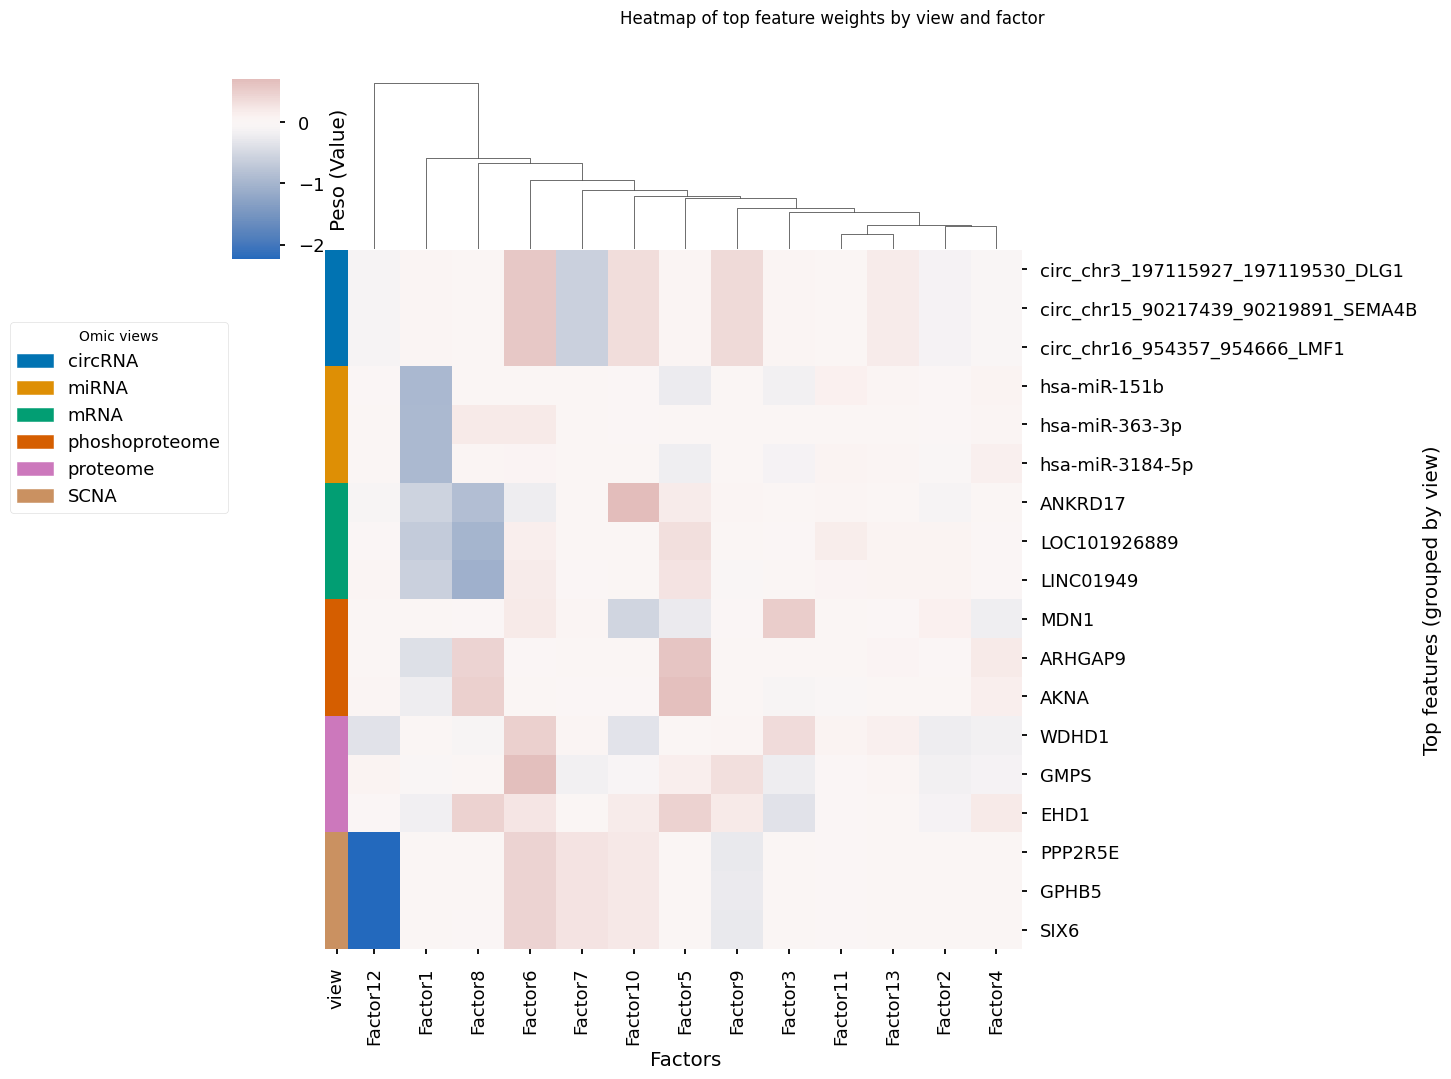

In [64]:
# heatmap of top feature weights per view and factor

model_file = "PDAC_mofa_model_ok.hdf5"
model = mofax.mofa_model(model_file)

N_TOP_FEATURES_PER_VIEW = 3     # number of top features to extract per view
all_top_weights_df_list = []

for view_name in labels:
    
    weights_df = model.get_weights(views=view_name, df=True)
    
    feature_variance = weights_df.var(axis=1)
    top_n_features = feature_variance.nlargest(N_TOP_FEATURES_PER_VIEW).index
    
    top_weights_df = weights_df.loc[top_n_features]
    
    top_weights_df["view"] = view_name
    all_top_weights_df_list.append(top_weights_df)

# heatmap of combined top features
combined_weights_df = pd.concat(all_top_weights_df_list, axis=0)

view_colors_dict = dict(zip(labels, sns.color_palette("colorblind", n_colors=len(labels))))
row_colors = combined_weights_df["view"].map(view_colors_dict)
df_to_plot = combined_weights_df.drop(columns="view")
clean_index = df_to_plot.index.str.replace(f"_(?:{'|'.join(labels)})$", "", regex=True)
df_to_plot.index = clean_index
row_colors.index = clean_index

# clustermap plot
g = sns.clustermap(
    df_to_plot,
    figsize=(12, 10), 
    cmap="vlag",
    center=0,
    yticklabels=True,
    row_colors=row_colors,
    dendrogram_ratio=(0.1, 0.2),
    cbar_kws={"label": "Peso (Value)"},
    row_cluster=False,
    cbar_pos=(0, 0.8, 0.04, 0.18)
)

g.ax_row_dendrogram.set_visible(False)
g.ax_heatmap.set_ylabel("Top features (grouped by view)")
g.ax_heatmap.set_xlabel("Factors")
plt.suptitle("Heatmap of top feature weights by view and factor", y=1.05)

handles = [plt.Rectangle((0,0),1,1, color=view_colors_dict[label]) for label in labels]
plt.legend(
    handles, 
    labels, 
    title="Omic views", 
    bbox_to_anchor=(0.1, -0.3),
    loc='upper right',
)

plt.show()
model.close()

In [65]:
# integration of MOFA Factors with Clinical Data

model_file = "PDAC_mofa_model_ok.hdf5"
model = mofax.mofa_model(model_file)
factors_df = model.get_factors(df=True)
model.close()

analysis_df = pd.merge(factors_df, clinical_data, left_index=True, right_index=True)

print(f"\nFinal analysis DataFrame created. Shape: {analysis_df.shape}\n")
print(analysis_df.columns)


Final analysis DataFrame created. Shape: (137, 37)

Index(['Factor1', 'Factor2', 'Factor3', 'Factor4', 'Factor5', 'Factor6',
       'Factor7', 'Factor8', 'Factor9', 'Factor10', 'Factor11', 'Factor12',
       'Factor13', 'histology_diagnosis', 'age', 'sex', 'race',
       'participant_country', 'tumor_site', 'tumor_size_cm', 'tumor_necrosis',
       'lymph_vascular_invasion', 'perineural_invasion',
       'pathologic_staging_regiol_lymph_nodes_pn',
       'pathologic_staging_primary_tumor_pt',
       'pathologic_staging_distant_metastasis_pm',
       'clinical_staging_distant_metastasis_cm', 'residual_tumor',
       'tumor_stage_pathological', 'additiol_pathologic_findings', 'bmi',
       'alcohol_consumption', 'tobacco_smoking_history', 'follow_up_days',
       'vital_status', 'is_this_patient_lost_to_follow_up', 'cause_of_death'],
      dtype='object')


# Data classification

Filtering 'weak labels': Removed 16 'Living' patients with follow-up < 365 days.
Ready for prediction. Number of samples: 117. Target distribution (pre-balancing):
| vital_status   |   proportion |
|:---------------|-------------:|
| Deceased       |         0.65 |
| Living         |         0.35 |

Training set distribution (before balancing):
vital_status
Deceased    53
Living      28
Name: count, dtype: int64

Training set distribution (after balancing):
vital_status
Deceased    28
Living      28
Name: count, dtype: int64

Training random forest

--- Model evaluation (on unbalanced test set) ---
Accuracy: 0.639

Classification report:
              precision    recall  f1-score   support

    Deceased       0.81      0.57      0.67        23
      Living       0.50      0.77      0.61        13

    accuracy                           0.64        36
   macro avg       0.66      0.67      0.64        36
weighted avg       0.70      0.64      0.64        36


--- MOFA Factors importanc

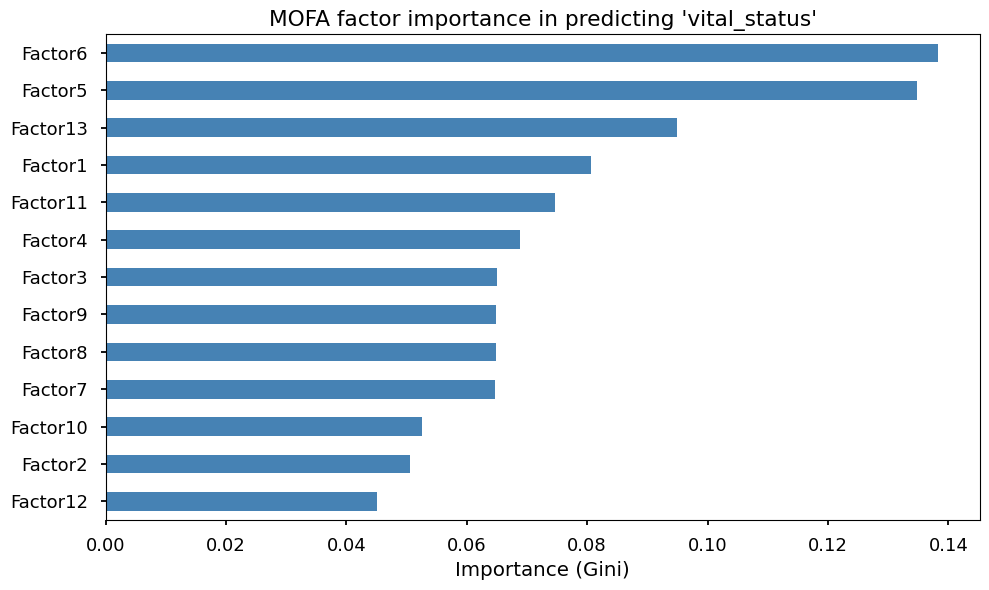

In [66]:
# prediction of 'vital_status' using MOFA factors with random forest classifier

target_variable = 'vital_status' 
factor_columns = factors_df.columns.tolist()
df_model = analysis_df[factor_columns + [target_variable, 'follow_up_days']].dropna(subset=[target_variable])

# remove 'weak labels': patients 'Living' with follow-up < 365 days
min_followup_days = 365
original_count = len(df_model)
df_model = df_model[~((df_model['vital_status'] == 'Living') & (df_model['follow_up_days'] < min_followup_days))]
print(f"Filtering 'weak labels': Removed {original_count - len(df_model)} 'Living' patients with follow-up < {min_followup_days} days.")

# x and y preparation
X = df_model[factor_columns]
y = df_model[target_variable]
print(f"Ready for prediction. Number of samples: {len(X)}. Target distribution (pre-balancing):")
print(y.value_counts(normalize=True).to_markdown(floatfmt=".2f"))

# train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.3,
    random_state=42, 
    stratify=y
)

# balancing the training set with RandomUnderSampler
print(f"\nTraining set distribution (before balancing):")
print(y_train.value_counts())
rus = RandomUnderSampler(random_state=42)
X_train_res, y_train_res = rus.fit_resample(X_train, y_train)
print(f"\nTraining set distribution (after balancing):")
print(y_train_res.value_counts())

# train the Random Forest Classifier
model_rf = RandomForestClassifier(n_estimators=100, random_state=42) 
print("\nTraining random forest")
model_rf.fit(X_train_res, y_train_res)

# evaluate the model on the test set
y_pred = model_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\n--- Model evaluation (on unbalanced test set) ---")
print(f"Accuracy: {accuracy:.3f}")
print("\nClassification report:")
print(classification_report(y_test, y_pred))

# feature importance extraction and plotting
importances = pd.Series(model_rf.feature_importances_, index=X.columns)
top_factors = importances.sort_values(ascending=False)
print("\n--- MOFA Factors importance for prediction ---")
print(top_factors.to_markdown(floatfmt=".3f"))

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(10, 6))
top_factors.sort_values().plot(kind='barh', color='steelblue')
plt.title(f"MOFA factor importance in predicting '{target_variable}'")
plt.xlabel("Importance (Gini)")
plt.tight_layout()

plt.show()

We tried to predict the **tumor_state_pathological**, but due to the imbalance of its values: 

- Stage IIB    52
- Stage III    42
- Stage IB     16
- Stage IV      9
- Stage IIA     8
- Stage IA      7
- NaN           6

Neither undersampling, nor oversampling, nor the adoption of a hybrid approach yielded satisfactory results in terms of prediction accuracy.

The same happened for the **pathologic_staging_regiol_lymph_nodes_pn**:

- pN1    54
- pN2    47
- pN0    31
- pNX     8

# Data clustering


Louvain algorithm completed. Found 4 clusters.
Cluster
0    53
3    48
1    35
2     1
Name: count, dtype: int64


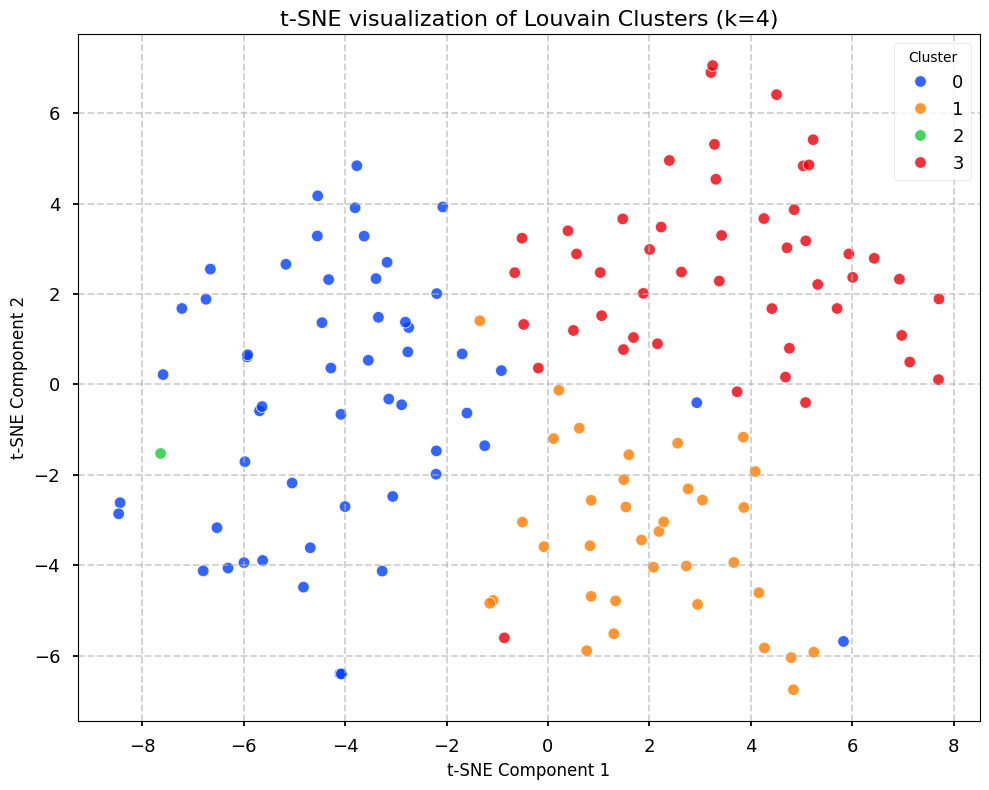

In [67]:
# clustering of patients based on MOFA factors using Louvain algorithm

X_cluster = analysis_df[factors_df.columns]

# build patient similarity graph using KNN approach
affinity_matrix = pairwise_distances(X_cluster, metric='euclidean')
gamma = 1.0 / X_cluster.shape[1] 
similarity_matrix = np.exp(-gamma * affinity_matrix**2)
G = nx.from_numpy_array(similarity_matrix)

# Louvain clustering for community detection
partition = community_louvain.best_partition(G, random_state=42)
louvain_clusters = [partition[i] for i in range(len(X_cluster))]
analysis_df['Cluster'] = louvain_clusters

n_clusters_found = len(set(louvain_clusters))
print(f"\nLouvain algorithm completed. Found {n_clusters_found} clusters.")
print(analysis_df['Cluster'].value_counts())

# t-SNE visualization of clusters
tsne = TSNE(
    n_components=2, 
    random_state=42,
    perplexity=30
)
tsne_results = tsne.fit_transform(X_cluster)

analysis_df['t-SNE 1'] = tsne_results[:, 0]
analysis_df['t-SNE 2'] = tsne_results[:, 1]

plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(10, 8))
sns.scatterplot(
    data=analysis_df,
    x='t-SNE 1',
    y='t-SNE 2',
    hue='Cluster',
    palette='bright',
    s=70,
    alpha=0.8
)
plt.title(f"t-SNE visualization of Louvain Clusters (k={n_clusters_found})", fontsize=16)
plt.xlabel("t-SNE Component 1", fontsize=12)
plt.ylabel("t-SNE Component 2", fontsize=12)
plt.legend(title="Cluster")
plt.grid(linestyle="--", alpha=0.6)
plt.tight_layout()

plt.show()

Cluster 2 is an **outlier** that we will study separately in subsequent analyses

In [ ]:
analysis_df[analysis_df['Cluster'] == 2]

,Factor1,Factor2,Factor3,Factor4,Factor5,Factor6,Factor7,Factor8,Factor9,Factor10,...,bmi,alcohol_consumption,tobacco_smoking_history,follow_up_days,vital_status,is_this_patient_lost_to_follow_up,cause_of_death,Cluster,t-SNE 1,t-SNE 2
C3L-02613,0.900525,-6.356198,1.518386,-1.463108,0.495568,4.144079,-4.722626,0.280506,1.535277,1.630869,...,26.84,Alcohol consumption equal to or less than 2 dr...,Lifelong non-smoker: Less than 100 cigarettes ...,211.0,Deceased,No,unknown,2,-7.637182,-1.527659


# Results interpretation

In [79]:
# Cluster Validation: Statistical Post-Hoc Testing
# Kruskal-Wallis for numeric, Chi-Square for categorical

warnings.filterwarnings("ignore")

# significance level
ALPHA = 0.05

# outlier clusters to remove
OUTLIER_CLUSTERS = [2] 

# variable type definitions
CATEGORICAL_COLS = [
    'histology_diagnosis', 'race', 'participant_country', 'tumor_site', 
    'tumor_necrosis', 'pathologic_staging_regiol_lymph_nodes_pn',
    'pathologic_staging_primary_tumor_pt', 'pathologic_staging_distant_metastasis_pm',
    'clinical_staging_distant_metastasis_cm', 'residual_tumor',
    'tumor_stage_pathological', 'alcohol_consumption', 'tobacco_smoking_history',
    'cause_of_death', 'lymph_vascular_invasion'
]
NUMERIC_COLS = [
    'age', 'bmi', 'tumor_size_cm', 'follow_up_days'
]
BINARY_COLS = [
    'sex', 'vital_status', 'perineural_invasion', 
    'is_this_patient_lost_to_follow_up'
]

# MOFA factor columns
factor_columns = factors_df.columns.tolist()

all_numeric_to_test = factor_columns + \
                      [col for col in NUMERIC_COLS if col in analysis_df.columns] + \
                      [col for col in BINARY_COLS if col in analysis_df.columns]
all_categorical_to_test = [col for col in CATEGORICAL_COLS if col in analysis_df.columns]

# filter outliers and encode binary cols
analysis_df_filtered = analysis_df[~analysis_df['Cluster'].isin(OUTLIER_CLUSTERS)].copy()
clusters_to_compare = sorted(analysis_df_filtered['Cluster'].unique())

le = LabelEncoder()
for col in BINARY_COLS:
    if col in analysis_df_filtered.columns and not pd.api.types.is_numeric_dtype(analysis_df_filtered[col]):
        analysis_df_filtered[col] = analysis_df_filtered[col].fillna('Missing')
        analysis_df_filtered[col] = le.fit_transform(analysis_df_filtered[col])

# run tests

print("--- Global Statistical Test Results (Kruskal-Wallis & Chi-Square) ---")
print(f"{'Variable':<45} | {'p-value':<12} | {'Result'}")
print("-" * 75)

# numeric, binary & factor variables (Kruskal-Wallis)
for var in all_numeric_to_test:
    if var not in analysis_df_filtered.columns:
        continue
    
    cluster_data_list = [analysis_df_filtered.loc[analysis_df_filtered['Cluster'] == c, var].dropna() for c in clusters_to_compare]
    
    if any(len(c_data) == 0 for c_data in cluster_data_list):
        continue
    
    try:
        stat, p_global = stats.kruskal(*cluster_data_list)
        
        if p_global < ALPHA:
            print(f"{var:<45} | p={p_global:<10.4e} | SIGNIFICANT")
        else:
            print(f"{var:<45} | p={p_global:<10.3f} | NOT SIGNIFICANT")
            
    except ValueError:
        pass 

# categorical variables (Chi-Square)
for var in all_categorical_to_test:
    if var not in analysis_df_filtered.columns:
        continue
        
    contingency_table = pd.crosstab(analysis_df_filtered['Cluster'], analysis_df_filtered[var])
    
    if contingency_table.shape[0] < 2 or contingency_table.shape[1] < 2:
        continue 
        
    try:
        chi2_stat, p_global, dof, expected = stats.chi2_contingency(contingency_table)
        
        if p_global < ALPHA:
            print(f"{var:<45} | p={p_global:<10.4e} | SIGNIFICANT")
        else:
            print(f"{var:<45} | p={p_global:<10.3f} | NOT SIGNIFICANT")
            
    except ValueError:
        pass 

print("-" * 75)
print(f"Test complete. Significance level ALPHA = {ALPHA}")

--- Global Statistical Test Results (Kruskal-Wallis & Chi-Square) ---
Variable                                      | p-value      | Result
---------------------------------------------------------------------------
Factor1                                       | p=1.2891e-02 | SIGNIFICANT
Factor2                                       | p=3.9545e-20 | SIGNIFICANT
Factor3                                       | p=4.9626e-14 | SIGNIFICANT
Factor4                                       | p=4.0466e-08 | SIGNIFICANT
Factor5                                       | p=0.055      | NOT SIGNIFICANT
Factor6                                       | p=8.5159e-03 | SIGNIFICANT
Factor7                                       | p=0.180      | NOT SIGNIFICANT
Factor8                                       | p=0.898      | NOT SIGNIFICANT
Factor9                                       | p=0.080      | NOT SIGNIFICANT
Factor10                                      | p=0.534      | NOT SIGNIFICANT
Factor11      

These results demonstrate that the clusters are effectively characterized by common factors, but there is no correlation among the clinical data of patients within the same cluster.

The two possible explanations we have considered are:

- There is genuinely no correlation between the omics views and the patients' clinical data.

- This issue stems from the fact that we performed clustering on the latent factors derived from MOFA. The data provided to MOFA is processed in various ways: features with many NAs are removed, and data imputation is performed using a method that is not particularly precise due to the multitude of data to eliminate the remaining NAs. This means that the input data for MOFA may not fully reflect reality.

To try and discover something more, we have decided to generate various plots.

Outlier clusters removed: [2]. Analysis on clusters: [np.int64(0), np.int64(1), np.int64(3)]
Found 15 categorical variables to profile.


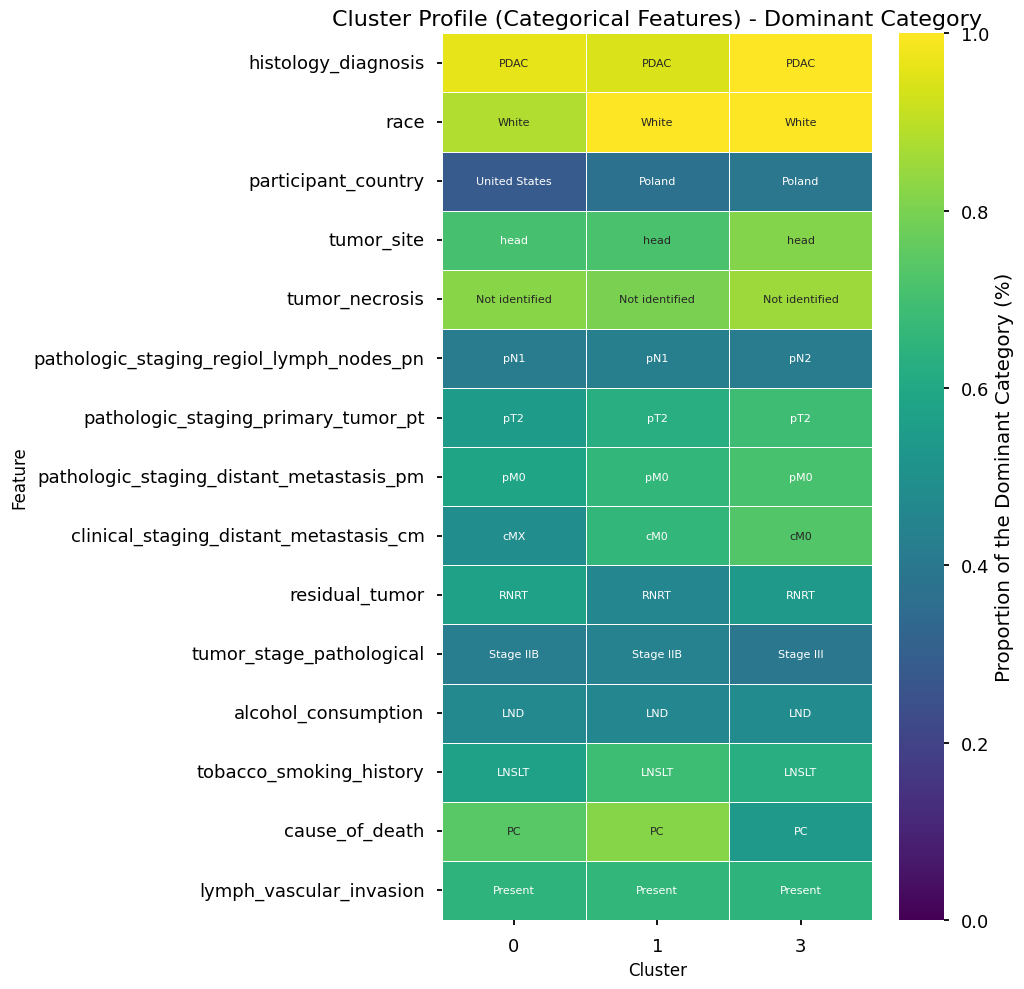


--- Acronym Legend ---
(printed because some labels were > 18 characters)
RNRT  : R0:  No residual tumor
LND   : Lifelong non-drinker
LNSLT : Lifelong non-smoker: Less than 100 cigarettes smoked in lifetime
PC    : pancreatic carcinoma


In [ ]:
# plot of categorical features distributions per cluster
 
analysis_df_filtered = analysis_df[~analysis_df['Cluster'].isin(OUTLIER_CLUSTERS)].copy()
clusters_to_profile = sorted(analysis_df_filtered['Cluster'].unique())
print(f"Outlier clusters removed: {OUTLIER_CLUSTERS}. Analysis on clusters: {clusters_to_profile}")

vars_to_run = [col for col in CATEGORICAL_COLS if col in analysis_df_filtered.columns]
print(f"Found {len(vars_to_run)} categorical variables to profile.")

# acronym logic to avoid long labels in heatmap
MAX_LEN = 18        # max length before acronym is created
acronym_legend = {} # dictionary to store acronyms and their full forms
def make_acronym(text):
    if not isinstance(text, str):
        return str(text)
    text = re.sub(r'\(.*\)', '', text)
    parts = re.split(r'[\s_\-:]+', text)
    acronym = "".join([part[0].upper() for part in parts if part])[:5]
    return acronym

# prepare heatmap data structures
heatmap_mode = pd.DataFrame(index=vars_to_run, columns=clusters_to_profile, dtype=object)
heatmap_proportion = pd.DataFrame(index=vars_to_run, columns=clusters_to_profile, dtype=float)

# iterate over variables and clusters to compute mode and proportion
for var in vars_to_run:
    for cluster in clusters_to_profile:
        cluster_data = analysis_df_filtered[analysis_df_filtered['Cluster'] == cluster][var].dropna()
        
        if cluster_data.empty:
            heatmap_mode.loc[var, cluster] = "N/A"
            heatmap_proportion.loc[var, cluster] = np.nan
            continue
            
        mode_val = cluster_data.mode().iloc[0]
        proportion = (cluster_data == mode_val).mean()
        
        display_val = str(mode_val)
        if len(display_val) > MAX_LEN:
            acronym = make_acronym(display_val)
            original_acronym = acronym
            count = 1
            while acronym in acronym_legend and acronym_legend[acronym] != display_val:
                acronym = f"{original_acronym}{count}"
                count += 1
            
            acronym_legend[acronym] = display_val
            display_val = acronym
            
        heatmap_mode.loc[var, cluster] = display_val
        heatmap_proportion.loc[var, cluster] = proportion

# plot heatmap
heatmap_proportion = heatmap_proportion.astype(float)
plt.figure(figsize=(10, 10))
sns.heatmap(
    heatmap_proportion, 
    annot=heatmap_mode,
    fmt='s',
    cmap='viridis',
    vmin=0.0,
    vmax=1.0,
    linewidths=.5,
    cbar_kws={'label': 'Proportion of the dominant category (%)'},
    annot_kws={"size": 8}
)
plt.title('Cluster profile (categorical features) - dominant category', fontsize=16)
plt.xlabel('Cluster', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()

plt.show()

if acronym_legend:
    print("\n--- Acronym legend ---")
    print("(printed because some labels were > 18 characters)")
    max_key_len = max(len(k) for k in acronym_legend.keys())
    for acr, full_text in acronym_legend.items():
        print(f"{acr:<{max_key_len}} : {full_text}")

Outlier clusters removed: [2]. Analysis on clusters: [np.int64(0), np.int64(1), np.int64(3)]
Found 8 numerical/binary variables to profile.


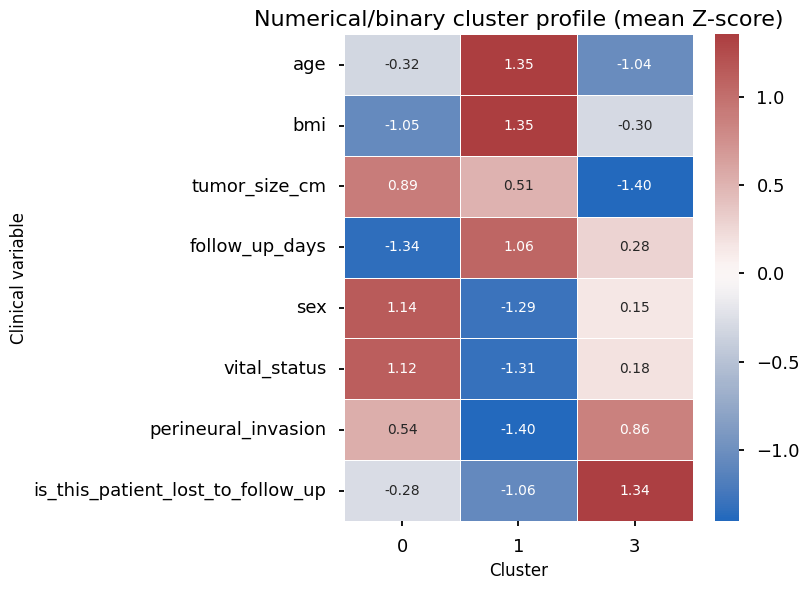

In [ ]:
# plot of numerical and binary features profiles per cluster

analysis_df_filtered = analysis_df[~analysis_df['Cluster'].isin(OUTLIER_CLUSTERS)].copy()
clusters_to_profile = sorted(analysis_df_filtered['Cluster'].unique())
print(f"Outlier clusters removed: {OUTLIER_CLUSTERS}. Analysis on clusters: {clusters_to_profile}")

cols_to_profile = [col for col in (NUMERIC_COLS + BINARY_COLS) if col in analysis_df_filtered.columns]
print(f"Found {len(cols_to_profile)} numerical/binary variables to profile.")

df_num_profile = analysis_df_filtered.copy()
le = LabelEncoder()

# Encode binary categorical variables
for col in BINARY_COLS:
    if col in df_num_profile.columns and not pd.api.types.is_numeric_dtype(df_num_profile[col]):
         # Nan handling: fill NaN with a placeholder before encoding
        df_num_profile[col] = df_num_profile[col].fillna('Missing')
        df_num_profile[col] = le.fit_transform(df_num_profile[col])

# compute mean per cluster
cluster_stats = df_num_profile.groupby('Cluster')[cols_to_profile].mean()

# apply z-score normalization across clusters for each variable
scaler = StandardScaler()
stats_scaled = scaler.fit_transform(cluster_stats)
stats_scaled_df = pd.DataFrame(
    stats_scaled, 
    index=cluster_stats.index, 
    columns=cluster_stats.columns
)

# plot heatmap
plt.figure(figsize=(max(8, len(clusters_to_profile) * 1.5), max(6, len(cols_to_profile) * 0.5)))
sns.heatmap(
    stats_scaled_df.T,
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidth=0.5
)
plt.title("Numerical/binary cluster profile (mean Z-score)", fontsize=16)
plt.ylabel("Clinical variable", fontsize=12)
plt.xlabel("Cluster", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Outlier clusters removed: [2]. Analysis on clusters: [np.int64(0), np.int64(1), np.int64(3)]

Mean factor profile per cluster (Z-scores):
|   Cluster |   Factor1 |   Factor2 |   Factor3 |   Factor4 |   Factor5 |   Factor6 |   Factor7 |   Factor8 |   Factor9 |   Factor10 |   Factor11 |   Factor12 |   Factor13 |
|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|----------:|-----------:|-----------:|-----------:|-----------:|
|         0 |    -0.049 |    -1.272 |    -0.902 |    -0.006 |    -0.261 |     0.019 |     0.093 |    -0.040 |     0.010 |     -0.101 |      0.030 |     -0.061 |     -0.079 |
|         1 |     0.296 |    -0.228 |     1.118 |     0.922 |     0.230 |    -0.254 |    -0.067 |     0.053 |     0.006 |      0.025 |      0.024 |      0.031 |      0.062 |
|         3 |    -0.181 |     1.703 |     0.150 |    -0.635 |     0.111 |     0.079 |     0.044 |    -0.000 |    -0.048 |      0.060 |     -0.056 |      0.054 |      

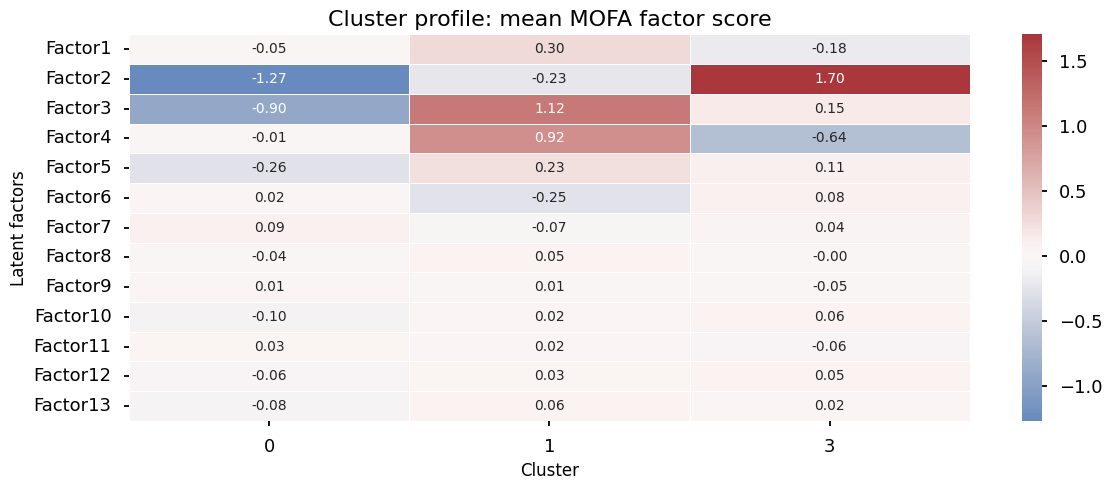

In [ ]:
# cluster profiling based on MOFA factors

analysis_df_filtered = analysis_df[~analysis_df['Cluster'].isin(OUTLIER_CLUSTERS)].copy()
clusters_to_profile = sorted(analysis_df_filtered['Cluster'].unique())
print(f"Outlier clusters removed: {OUTLIER_CLUSTERS}. Analysis on clusters: {clusters_to_profile}")

# compute mean factor scores per cluster
factor_columns = factors_df.columns.tolist()
cluster_factor_profiles = analysis_df_filtered.groupby('Cluster')[factor_columns].mean()
print("\nMean factor profile per cluster (Z-scores):")
print(cluster_factor_profiles.to_markdown(floatfmt=".3f"))


# heatmap of factor profiles per cluster
plt.style.use('seaborn-v0_8-talk')
plt.figure(figsize=(12, 5))
sns.heatmap(
    cluster_factor_profiles.T, 
    annot=True,
    fmt=".2f",
    cmap="vlag",
    center=0,
    linewidth=0.5
)

plt.title("Cluster profile: mean MOFA factor score", fontsize=16)
plt.ylabel("Latent factors", fontsize=12)
plt.xlabel("Cluster", fontsize=12)
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()

plt.show()


Processing: Factor2

Processing: Factor3

Processing: Factor4


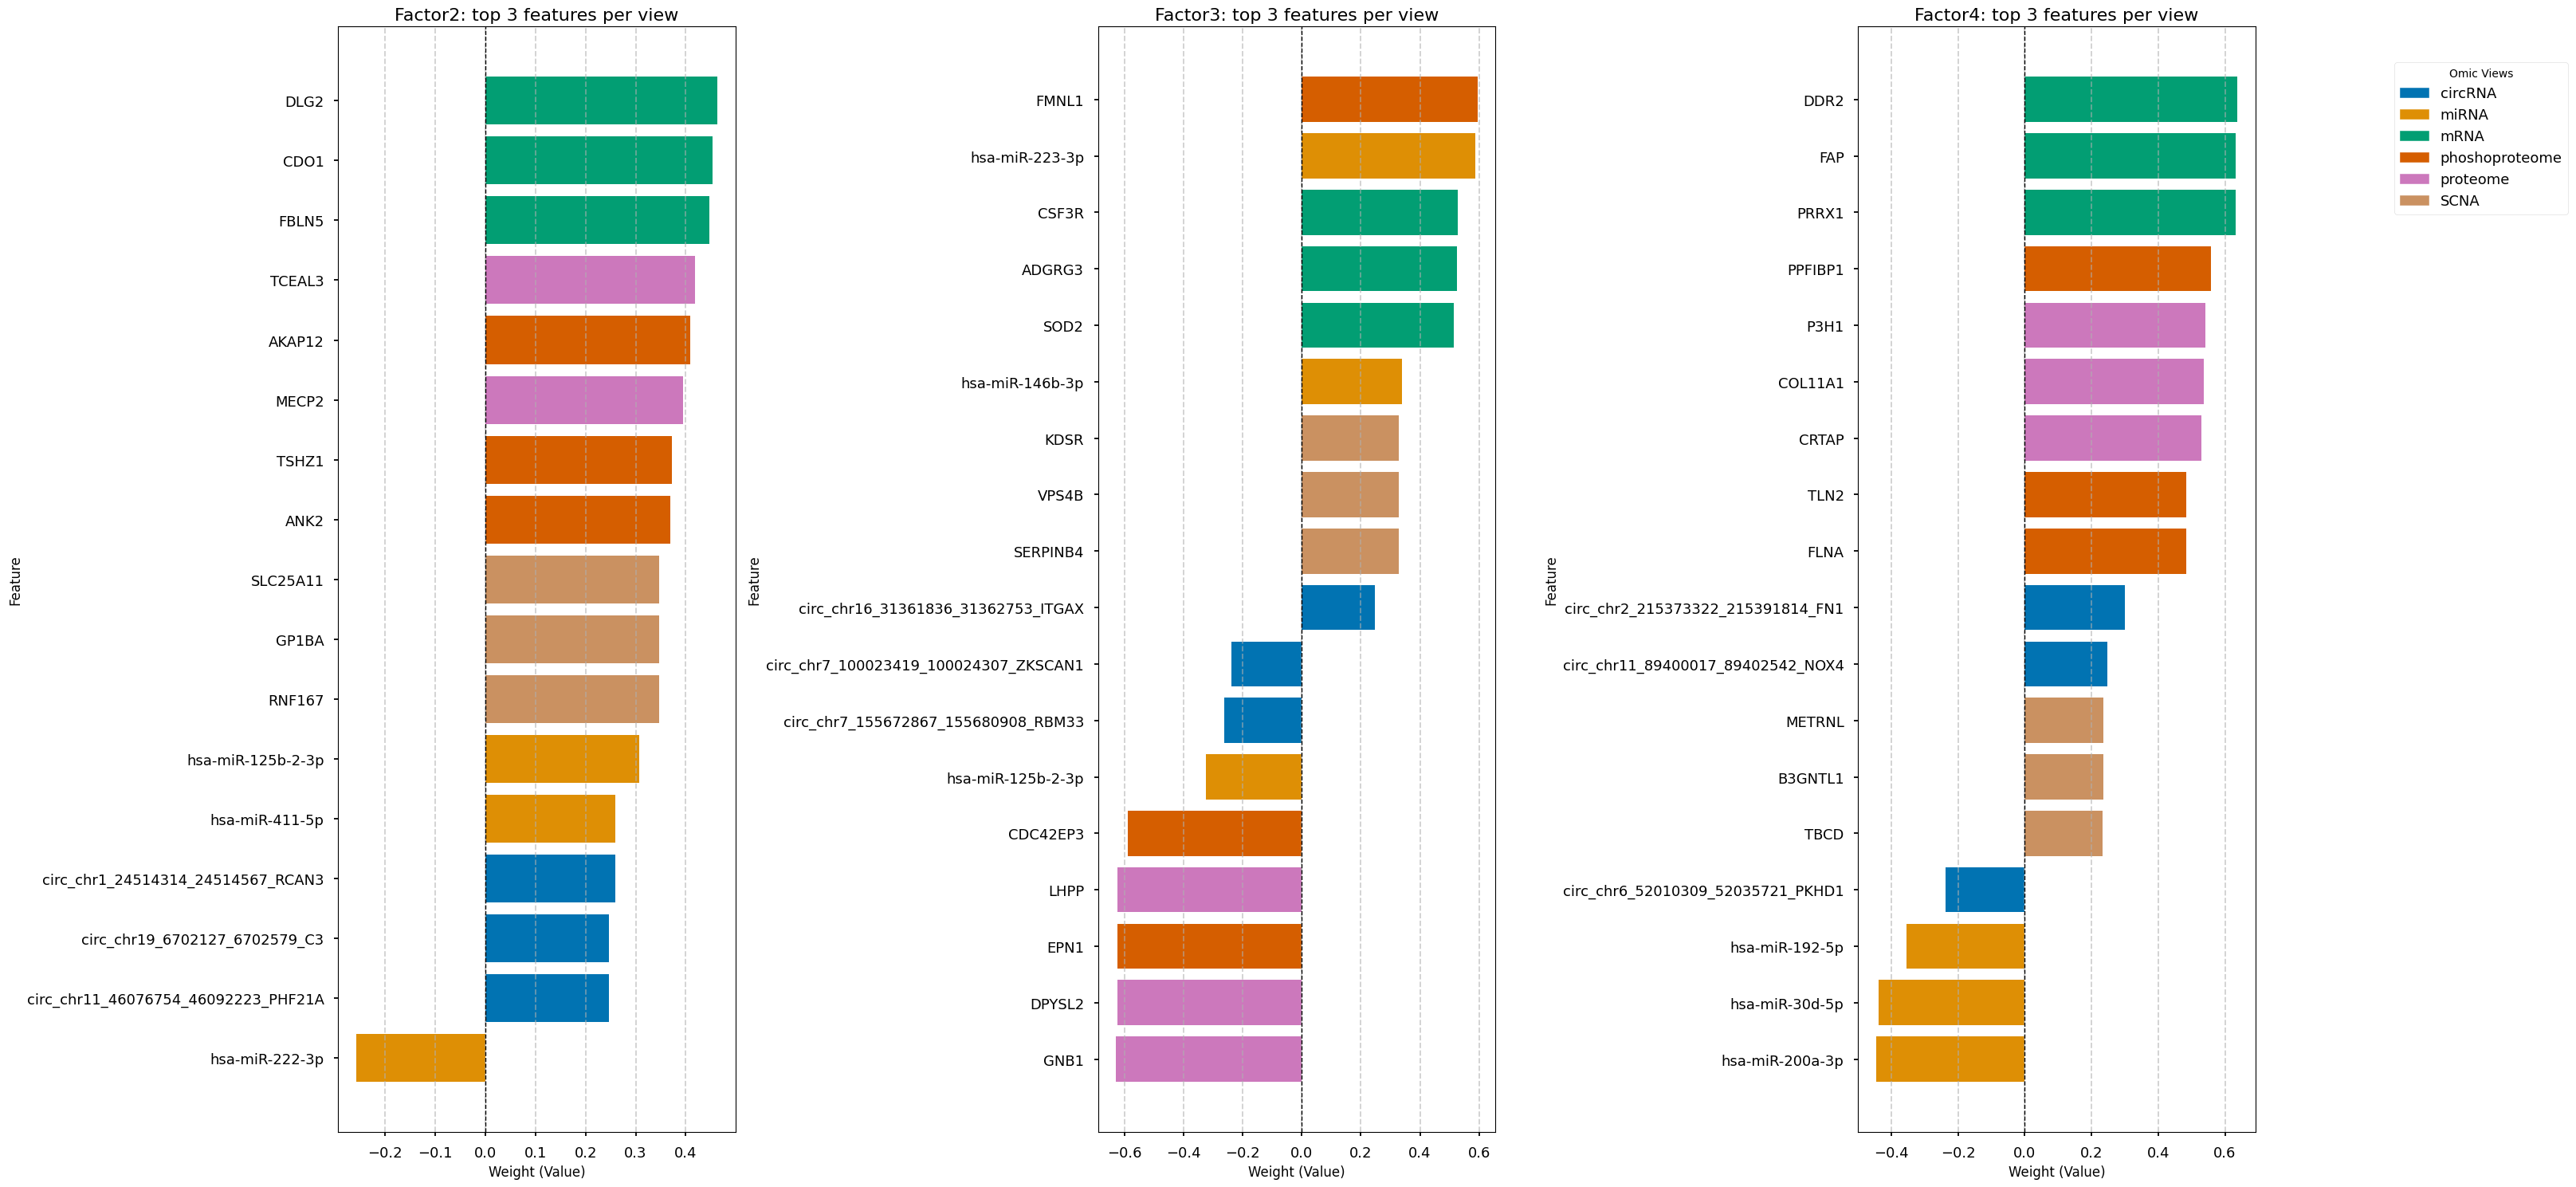

In [ ]:
model_file = "PDAC_mofa_model_ok.hdf5"
model = mofax.mofa_model(model_file)

factors_to_analyze = ["Factor2", "Factor3", "Factor4"] # 3 factors for a 1x3 grid
N_top_features = 3  # number of top features to extract per view

# --- Setup Figure ---
# Create a 1x3 grid of subplots (one for each factor)
# We set a generous fixed height, assuming plot_height would be similar for all
fig, axes = plt.subplots(1, 3, figsize=(30, 15)) 

# Ensure `labels` (view names) is defined, used for colors and legend
# Example: labels = ["circRNA", "miRNA", "mRNA", "mutations", "clinical"]
view_colors_dict = dict(zip(labels, sns.color_palette("colorblind", n_colors=len(labels))))

# --- Iterate over each factor AND its corresponding axis ---
for factor_to_analyze, ax in zip(factors_to_analyze, axes):
    
    print(f"\nProcessing: {factor_to_analyze}")
    
    # extract top features
    top_features_df = model.get_top_features(
        factors=factor_to_analyze,
        n_features=N_top_features,
        df=True
    )

    if top_features_df.empty:
        print(f"No significant features found for {factor_to_analyze}. Skipping plot.")
        ax.set_title(f"{factor_to_analyze}\n(No features found)", fontsize=16)
        ax.set_visible(False) # Hide this subplot
        continue

    # feature name cleaning
    top_features_df["feature_clean"] = top_features_df["feature"].str.replace(
        f"_(?:{'|'.join(labels)})$", "", regex=True
    )

    top_features_df = top_features_df.sort_values(by="value")
    
    # plot
    bar_colors = top_features_df["view"].map(view_colors_dict)

    # Plot on the specific axis (ax)
    ax.barh(
        top_features_df["feature_clean"], 
        top_features_df["value"],
        color=bar_colors
    )

    ax.set_title(f"{factor_to_analyze}: top {N_top_features} features per view", fontsize=16)
    ax.set_xlabel("Weight", fontsize=12)
    ax.set_ylabel("Feature", fontsize=12)
    ax.grid(axis="x", linestyle="--", alpha=0.6)
    ax.axvline(0, color='black', linestyle='--', linewidth=1)

# --- Finalize Figure ---

# Create one shared legend for the entire figure
handles = [plt.Rectangle((0,0),1,1, color=view_colors_dict[label]) for label in labels]
# Place legend outside the plots (to the right of the figure)
fig.legend(handles, labels, title="Omic views", bbox_to_anchor=(1.0, 0.95), loc='upper left')

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0, 0.95, 1]) 

plt.show()
    
model.close()

After analyzing these graphs, we drew some conclusions:

- the graphs show differences between the various clusters, which were not highlighted by the statistical tests.

- the difference between the relevant factors according to the statistical tests and the heatmap comes from the fact that the mean values do not truly represent the data, but since they were continuous variables, they were the best measure for visualization.

Despite previous findings that highlighted controversies in our analyses (the fact that the clinical data are not statistically significant), we still tried to profile the patients in each cluster based on all the information we had available.

[Gemini analysis]

**Patient cluster 0 profile**
- **Clinical view**: this cluster's profile is complex, defined by high "Living" vital_status (+1.12) but also very short follow_up_days (-1.34). This suggests their "Living" status may be an artifact of short-term follow-up. This is a high-risk group, characterized by being predominantly male (+1.14), having larger tumors (+0.89), and being associated with pathologic_staging_regiol_lymph_nodes_pn of pN1 and tumor_stage_pathological of Stage IIB.

- **Biological view**: the multi-omic signature of this cluster is defined by what it lacks. It is strongly defined by negative scores for Factor 2 (-1.27) and Factor 3 (-0.90). This implies a systemic suppression of the biological programs associated with those factors: low expression of the F2 program (e.g., DLG2, AKAP12, TCEAL3) and the F3 program (e.g., FMNL1, CSF3R).
  
**Patient cluster 1 profile**
- **Clinical view**: this cluster represents a distinct long-term prognosis group. It is strongly characterized by "Deceased" vital_status (Z-score -1.31), despite having a long follow_up_days (+1.06). Clinically, this group is predominantly female (-1.29), has a higher BMI (+1.35) and shows low perineural_invasion (-1.40). Categorically, this group is also associated with tumor_stage_pathological Stage IIB.

- **Biological view**: this group's signature is one of activation. It is defined by strong positive scores for Factor 3 (+1.12) and Factor 4 (+0.92). This indicates a high expression of the F3 program (e.g., FMNL1, CSF3R, SOD2) and the F4 program (e.g., DDR2, FAP, COL11A1), while simultaneously suppressing their respective inhibitors (like hsa-miR-200a-3p or GNB1).
  
**Patien cluster 2 profile**
- patient ID **C3L-02613** was the only representative of cluster 2. However, its clinical profile is very similar to that of the patients in cluster 0, which is very close according to the 2D t-SNE visualization. Therefore, this patient is likely to have a different biological profile but present the same clinical characteristics as the patients in Cluster 0.

**Patient cluster 3 profile**
- **Clinical view**: this cluster is defined by advanced tumor stage. It is the only group with a dominant category of tumor_stage_pathological Stage III and pathologic_staging_regiol_lymph_nodes_pn of pN2. Interestingly, despite this advanced stage, these patients tend to be younger (-1.04) and have smaller tumors (-1.40) than Cluster 0.

- **Biological view**: the biology of this cluster is overwhelmingly dominated by Factor 2. It is defined by a massive positive score for Factor 2 (+1.70). This implies a powerful and widespread activation of the entire F2 multi-omic program, including mRNA (e.g., DLG2, CDO1), phoshoproteome (e.g., AKAP12, ANK2), and proteome (e.g., TCEAL3).